In [316]:
import sys
sys.path.append('../..')
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

import numpy as np
import Phys
import random
import h5py
# physical constants in cgs units
constants = Phys.ReadPhys()

from SpecWizard_Input import ReadData
from SpecWizard_BuildInput import Build_Input
from SpecWizard_ProjectData import SightLineProjection
import importlib
import SpecWizard_ComputeOpticaldepth
from SpecWizard_SaveOpticaldepth import OpticalDepth_IO

import SpecWizard_AnalyseOpticaldepth
SpecWizard_AnalyseOpticaldepth = importlib.reload(SpecWizard_AnalyseOpticaldepth)
from SpecWizard_AnalyseOpticaldepth import Analyse_Opticaldepth


SpecWizard_ComputeOpticaldepth = importlib.reload(SpecWizard_ComputeOpticaldepth)

from SpecWizard_ComputeOpticaldepth import ComputeOpticaldepth

import eagleSqlTools as sql
import numpy as np
import multiprocessing

## Introduction 

Here we try to replicate Figure 3 from [(Turner et al 2017)](https://ui.adsabs.harvard.edu/abs/2017MNRAS.471..690T/abstract). Where ...

## Querying the database 

We set up the functions to queary the Eagle data base to get the galaxy information for certain mass treshold for the Reference L0100N1504 

In [16]:
me     = "tt"
mine   = "vr983MZL"
conSQL = sql.connect(me, password=mine)
simname   = {'sql':'RefL0100N1504','particles':'L0100N1504/PE/REFERENCE/'}
variables = [{'type':1, 'name':'Coordinates'}]
snapnum   = 14

m_min = 10**(12.5)
sqlpars   = { 'm_min':m_min,  'fraction':1}   # select halos with given mass

In [17]:
# sql query parameters
class Eagle:
    def __init__(self, simname=simname, sqlpars=sqlpars,snapnum=snapnum):
        ''' Methods to interface SQL database and particles from snapshots '''
        self.snapnum    = snapnum
        self.simname    = simname   # particlular simulation

        # read header of snapshot data
        self.eaglebase  = '/cosma7/data/Eagle/ScienceRuns/Planck1/'
        self.subbase    = 'snapshot_'
        self.partbase   = 'snap_'
        # create file name
        file            = self.eaglebase + self.simname['particles'] + '/data/' + self.subbase 
        file           += self.snapbase(snapnum) + '/' + self.partbase + self.snapbase(snapnum) + '.0.hdf5'
        self.fname      = file
    def QueryDB(self, sqlpars):
        ''' Query data base '''
        mhistory = '''SELECT
                          SubHalo.Mass as m200,
                          SubHalo.MassType_Star as m_star,
                          SubHalo.CentreOfPotential_x as pos_x,
                          SubHalo.CentreOfPotential_y as pos_y,
                          SubHalo.CentreOfPotential_z as pos_z,
                          SubHalo.Velocity_x as vel_x,
                          SubHalo.Velocity_y as vel_y,	
                          SubHalo.Velocity_z as vel_z                         
                  FROM 
                          {simname}_SubHalo as SubHalo 
                  WHERE 
                          SubHalo.Mass > {m_min:1.2e}
                          and SubHalo.SubGroupNumber = 0 
                          and SubHalo.RandomNumber < {fraction:3f}
                          and SubHalo.Snapnum = {snapnum:3d}
                  ORDER BY 
                          SubHalo.Mass desc'''.format(
                                                     simname=self.simname['sql']
                                                    ,m_min=sqlpars['m_min']
                                                    , fraction = sqlpars['fraction']
                                                    , snapnum=self.snapnum)
                                                
        return sql.execute_query(conSQL, mhistory)
        
        
        
    def snapbase(self, snapnum=28):
        ''' return file base for particle file '''
        bases      = ['000_z020p000', '001_z015p132', '002_z009p993'
                  , '003_z008p988', '004_z008p075', '005_z007p050'
                  , '006_z005p971', '007_z005p487', '008_z005p037'
                  , '009_z004p485', '010_z003p984', '011_z003p528'
                  , '012_z003p017', '013_z002p478', '014_z002p237'
                  , '015_z002p012', '016_z001p737', '017_z001p487'
                  , '018_z001p259', '019_z001p004', '020_z000p865'
                  , '021_z000p736', '022_z000p615', '023_z000p503'
                  , '024_z000p366', '025_z000p271', '026_z000p183'
                  , '027_z000p101', '028_z000p000']
        try:
            return bases[snapnum]
        except:
            print('This snapshot does not exists, sorry')
        

In [18]:
m_min = 10**(12.5)
sqlpars   = { 'm_min':m_min,  'fraction':1} 

eagle = Eagle()
halos = eagle.QueryDB(sqlpars)

With this we get the information of 91 subhalos that have a $\log_{10} m_{200}>12.0$ 

In [19]:
print("Number of halos: ", len(halos))

Number of halos:  91


And we can access to the information 

## Setting up SW to get the information

In [2]:
BuildInput = Build_Input()


In [3]:
BuildInput = Build_Input()

Wizard = BuildInput.read_from_yml()

Warning! SightLength NOT found. Setting default value: 1


In [4]:
snapshot  = ReadData(wizard = Wizard)
data                = snapshot.read_particles()

In [5]:
snapshot  = ReadData(wizard = Wizard)
data                = snapshot.read_particles()
sightlineprojection  = SightLineProjection(Wizard)
projected_LOS = sightlineprojection.ProjectData(data)

/cosma/local/Python/3.6.5/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
../../SpecWizard_IonTables.py:129: RuntimeWarning: divide by zero encountered in log10
  LogAbundance = np.log10(hf['ionbal'][...])


In [21]:
a_fact = 1/ (snapshot.header['Cosmo']['Redshift'] + 1)

In [22]:
random_indx25_2p23 = random.sample(range(0,len(halos)),91)

In [250]:
print(halos[3]['pos_x'],halos[3]['pos_y'],halos[3]['pos_z'])

17.103365 82.338615 49.80261


Let's crate a grid of LOS for each galaxy. We can do a impact parameter from 0 to 1 pMpc and a los length of 4 pMpc. 

In [24]:
BoxSim_cMpc = 100
dx_cMpc = 2/a_fact  / BoxSim_cMpc
dz_cMpc = 8/a_fact / BoxSim_cMpc

In [25]:
dx_cMpc * BoxSim_cMpc

6.474073786164985

In [26]:
xmin    = 0.04
xmax    = 2.04
npix_x    = 200


In [27]:
dx_grid = np.logspace(np.log10(0.04/a_fact),np.log10(2/a_fact),200)
dx_grid_frac = dx_grid/100

In [18]:
hubble_vel_z = snapshot.Hubble() * a_fact * (halos['pos_z']) + halos['vel_z']

In [882]:
Wizard

dict_keys(['ProjectionAxes', 'x-axis', 'y-axis', 'z-axis', 'ProjectionStart', 'x-position', 'y-position', 'z-position', 'ProjectionLength', 'SightLength', 'ProjectionExtend', 'nsight', 'Boxkms', 'Box', 'short-LOS', 'sightkms'])

In [251]:
Wizard['sightline']['ProjectionStart'] = [0.1710,0.8233,0]
Wizard['sightline']['x-position'] = 0.1710
Wizard['sightline']['y-position'] = 0.8233

In [252]:
snapshot  = ReadData(wizard = Wizard)
data                = snapshot.read_particles()
sightlineprojection  = SightLineProjection(Wizard)
projected_LOS = sightlineprojection.ProjectData(data)

/cosma/local/Python/3.6.5/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
../../SpecWizard_IonTables.py:129: RuntimeWarning: divide by zero encountered in log10
  LogAbundance = np.log10(hf['ionbal'][...])


In [253]:
snapshot.ToCGS(projected_LOS['Mass-weighted']['Temperatures']).max()

35067331.39292458

In [254]:
np.log10(snapshot.ToCGS(projected_LOS['Element-weighted']['Hydrogen']['Densities']).max()/constants['mH'])

-1.2483598475232291

(3400.0, 3600.0)

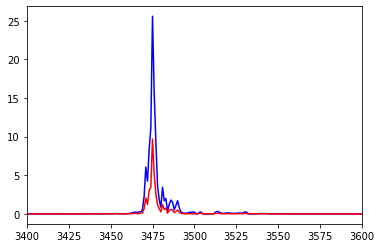

In [273]:
plt.plot(projected_LOS['Element-weighted']['Carbon']['Densities']['Value'],c='blue')
plt.plot(projected_LOS['Element-weighted']['Silicon']['Densities']['Value'],c='red')
plt.xlim(3400,3600)

(3400.0, 3600.0)

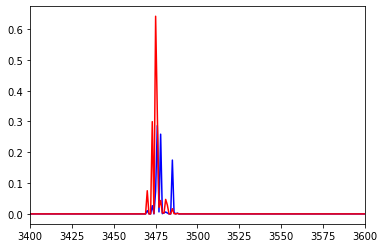

In [274]:
plt.plot(projected_LOS['Ion-weighted']['C IV']['Densities']['Value'],c='blue')
plt.plot(projected_LOS['Ion-weighted']['Si IV']['Densities']['Value'],c='red')
plt.xlim(3400,3600)

In [275]:
cspec          = ComputeOpticaldepth(Wizard)
opticaldepth   = cspec.MakeAllOpticaldepth(projected_LOS)

../../SpecWizard_ComputeOpticaldepth.py:210: RuntimeWarning: invalid value encountered in sqrt
  bions_kms = np.sqrt(2*self.constants["kB"]*Tions/weight) / 1e5


(3400.0, 3600.0)

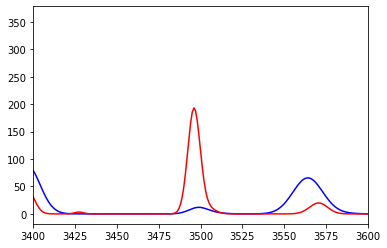

In [283]:
plt.plot(((opticaldepth[('Carbon', 'C IV')]['Optical depths']['Value'])),c='blue')
plt.plot(((opticaldepth[('Silicon', 'Si IV')]['Optical depths']['Value'])),c='red')
plt.xlim(3400,3600)

In [294]:

tc4 = opticaldepth[('Carbon', 'C IV')]['Optical depths']['Value']
tsi4 = opticaldepth[('Silicon', 'Si IV')]['Optical depths']['Value']
wave = np.arange(len(tc4))
spectrum = {'wave':wave,'flux':np.exp(-tsi4),'L':wave[-1]}

In [295]:
from scipy.signal import convolve

def Convolve(spectrum, FWHM):
    ''' Convolve the spectrum with instrumental broadining
     Input: 
       -spectrum: dictionary, containing
          -L:       linear extent of the array wavelength range
          -wave:    wavelength or Hubble velocity
          -flux:    flux
       -FWHM:       full-width at half maximum of the Gaussian line-spread function
    Output: the convolved spectrum in the form of a dictionary
    '''
    wave = spectrum["wave"]
    dx   = wave[1:] - wave[0:-1]
    dx   = np.concatenate([dx, [spectrum['L']-wave[-1]]])
    wave = wave + 0.5 * dx
    flux = spectrum["flux"]

    # create Gaussian
    sigmaG    = FWHM / (2*np.log(2))  # Gaussian's standard deviation
    n         = len(wave)
    if even(n):
        nc = np.int(n/2-1)
    else:
        nc = np.int((n+1)/2)-1
    waveG     = wave - wave[nc]
    Gauss     = np.exp(-(waveG)**2 / (2*sigmaG**2)) / (np.sqrt(2.*np.pi*sigmaG**2))
    #
    convolved = convolve(flux, Gauss, mode='same') / np.sum(Gauss)
    # convolved = flux
    #
    newspectrum = spectrum.copy()
    newspectrum["flux"] = convolved
    newspectrum["FWHM"] = FWHM
    return newspectrum
def even(n):
    # return true if input n is even, else returns false
    if (np.int(n/2)*2 == n):
        return True
    else:
        return False

In [459]:
len(spectrum['wave'])/2.5

2791.2

In [478]:
spectrum['wave'][-1]

6977

In [479]:
new_kms = np.arange(0,6977+2.5,2.5)

In [480]:
new_kms[-1]

6977.5

In [481]:
rebinned_si = AO.Rebin(spectrum['flux'],new_kms)

In [293]:
instrument_c4  = Convolve(spectrum, 8.5)

In [296]:
instrument_si4  = Convolve(spectrum, 8.5)

In [491]:
np.array([3400,3600])/2.5

array([1360., 1440.])

In [492]:
print(np.median(tsi4[3400:3600]),np.median(-np.log(instrument_c4['flux'][3400:3600])),np.median(-np.log(rebinned_si[1360:1440])))

0.06509648916593402 0.9628608365963882 0.09060062677645793


/cosma/home/dp004/dc-aram1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [305]:
print(np.median(tc4[3400:3600]),np.median(tsi4[3400:3600]),np.median(-np.log(instrument_c4['flux'][3400:3600])),np.median(-np.log(instrument_si4['flux'][3400:3600])))

1.2039527166636257 0.06509648916593402 0.9628608365963882 0.37989242965267017


(3200.0, 3800.0)

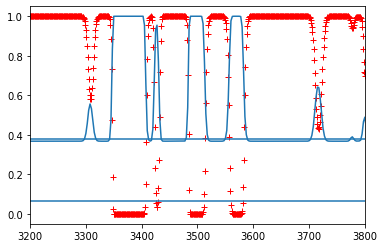

In [483]:
##plt.plot(np.exp(-(opticaldepth[('Carbon', 'C IV')]['Optical depths']['Value'])),'+',c='blue')
plt.plot(spectrum['wave'],np.exp(-(opticaldepth[('Silicon', 'Si IV')]['Optical depths']['Value'])),'+',c='red')
plt.plot(new_kms,np.exp(-(rebinned_si)))
plt.axhline(y= 0.0650964891659340)
plt.axhline(y= 0.37989242965267017)
#plt.plot(instrument_c4['flux'])
#plt.plot(instrument_si4['flux'])
plt.xlim(3400,3600)
plt.xlim(3200,3800)

(3400.0, 3600.0)

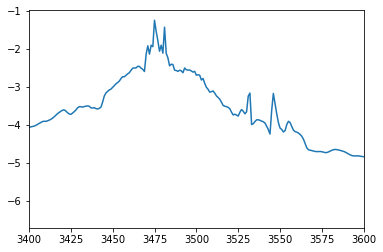

In [257]:
plt.plot(np.log10(snapshot.ToCGS(projected_LOS['Element-weighted']['Hydrogen']['Densities'])/constants['mH']))
plt.xlim(3400,3600)

In [317]:
AO = Analyse_Opticaldepth(wizard=Wizard)

In [319]:
class_out = AO.Convolve(np.exp(-tc4),8.5)

In [323]:
(instrument_c4['flux']-class_out['flux']).max()

0.0

(3000.0, 4000.0)

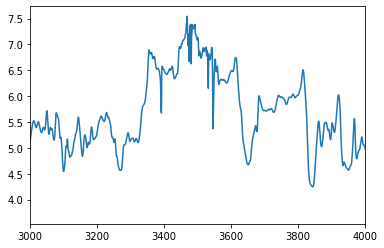

In [259]:
plt.plot(np.log10(snapshot.ToCGS(projected_LOS['Mass-weighted']['Temperatures'])))
plt.xlim(3000,4000)

In [269]:
opticaldepth[('Silicon', 'Si IV')]['f-value']*opticaldepth[('Silicon', 'Si IV')]['lambda0']

714.9963150000001

In [270]:
opticaldepth[('Carbon', 'C IV')]['f-value']*opticaldepth[('Carbon', 'C IV')]['lambda0']

294.15553

In [1635]:
len(projected_LOS['Mass-weighted']['Densities']['Value'])

1635

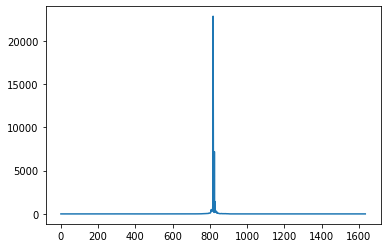

In [1634]:
plt.plot(projected_LOS['Mass-weighted']['Densities']['Value'])

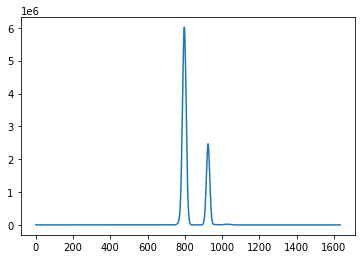

In [1630]:
plt.plot(opticaldepth[('Hydrogen', 'H I')][ 'Optical depths']['Value'])

In [19]:
def do_sight(isight,projections):
    # read the particle data
    xstart = x + dx_grid_frac[isight]*np.cos(phi[isight])
    ystart = y + dx_grid_frac[isight]*np.sin(phi[isight])
    zstart = 0#z - (0.5*dz_cMpc)
    Wizard = BuildInput.Sightline(ProjectionAxes=('simx','simy','simz'),ProjectionStart=[xstart,ystart,zstart],ProjectionLength=1)
    snapshot  = ReadData(wizard = Wizard)
    data                = snapshot.read_particles()
    # project the particle data
    sightlineprojection  = SightLineProjection(Wizard)

    projected_LOS = sightlineprojection.ProjectData(data)

    Wizard['sightline']['ProjectionExtend']["extend"]          = False
    Wizard['sightline']['ProjectionExtend']["extendfactor"]    = 10
    Wizard['ODParams']['VoigtOff']= True
    cspec          = ComputeOpticaldepth(Wizard)
    opticaldepth   = cspec.MakeAllOpticaldepth(projected_LOS)
    result                = {"nsight": isight,  
                             'OpticaldepthWeighted':opticaldepth,
                              'Projection':projected_LOS,
                              "Wizard":Wizard}
    projections[isight] = result

In [23]:
random_indx100 = [78,3,79,83,105,26,32,6,50,48,82,17,10,59,0,66,31,119,9,20,76,67,51,117,44,68,8,98,103,104,72,86,35,54,90,12,88,81,71,14,120,63,39,16,80,100,114,64,
 108,
 109,
 91,
 40,
 15,
 92,
 52,
 73,
 38,
 22,
 33,
 41,
 11,
 30,
 61,
 21,
 74,
 28,
 42,
 57,
 62,
 53,
 4,
 1,
 58,
 113,
 107,
 70,
 77,
 46,
 96,
 37,
 87,
 89,
 60,
 65,
 56,
 18,
 115,
 97,
 13,
 43,
 111,
 29,
 36,
 23,
 34,
 19,
 102,
 69,
 85,
 93]

In [557]:
halos[random_indx25_2p23]['m200']

array([5.8894105e+12, 8.1756999e+12, 4.5413344e+12, 3.3862708e+12,
       5.7109229e+12, 1.2458804e+13, 4.4272221e+12, 3.3464241e+12,
       3.4610864e+12, 4.0187910e+12, 3.1719385e+12, 8.7309854e+12,
       3.5877589e+12, 7.2106744e+12, 3.1887471e+12, 3.6831704e+12,
       3.9909867e+12, 5.1105880e+12, 3.1817277e+12, 3.9476341e+12,
       4.8291580e+12, 3.3376287e+12, 2.0970362e+13, 4.0346216e+12,
       7.0334425e+12, 4.4820915e+12, 7.6465559e+12, 5.7372773e+12,
       3.3333557e+12, 4.2458703e+12, 4.6525013e+12, 5.1631164e+12,
       3.8929750e+12, 4.4594868e+12, 6.0996662e+12, 3.3640871e+12,
       3.6452022e+12, 5.4923766e+12, 6.4104369e+12, 5.7458678e+12,
       4.1810647e+12, 5.9696333e+12, 6.2535128e+12, 3.4661657e+12,
       5.7892777e+12, 1.6430266e+13, 1.5588812e+13, 7.4422105e+12,
       3.4278369e+12, 3.2916848e+12, 4.1841522e+12, 9.1852080e+12,
       3.3264970e+12, 3.7962714e+12, 3.8878417e+12, 1.1114255e+13,
       7.1444427e+12, 1.0983225e+13, 1.2285192e+13, 6.0816265e

In [553]:
galn=12    
nsight = len(dx_grid_frac)     # number of sight lines to compute
np.random.seed(galn)
phi = 2*np.pi*np.random.uniform(size=nsight)
x = halos[random_indx25_2p23[galn]]['pos_x']/BoxSim_cMpc
y = halos[random_indx25_2p23[galn]]['pos_y']/BoxSim_cMpc

for i in range(0,nsight):
    xstart = x + dx_grid_frac[i]*np.cos(phi[i])
    ystart = y + dx_grid_frac[i]*np.sin(phi[i])

    print(np.array([dx_grid_frac[i],x,y,xstart,ystart,np.sqrt((xstart-x)**2+(ystart-y)**2)])*100*a_fact)

[ 0.04       27.74656371 15.05945417 27.76922075 15.09241867  0.04      ]
[ 0.04079412 27.74656371 15.05945417 27.74401494 15.01873975  0.04079412]
[ 0.041604   27.74656371 15.05945417 27.74308715 15.10091265  0.041604  ]
[ 0.04242996 27.74656371 15.05945417 27.70508359 15.05052662  0.04242996]
[ 0.04327232 27.74656371 15.05945417 27.78965471 15.06341139  0.04327232]
[ 0.0441314  27.74656371 15.05945417 27.78506777 15.0378899   0.0441314 ]
[ 0.04500753 27.74656371 15.05945417 27.78309403 15.03316321  0.04500753]
[ 0.04590106 27.74656371 15.05945417 27.79145644 15.06902238  0.04590106]
[ 0.04681233 27.74656371 15.05945417 27.79167389 15.0469455   0.04681233]
[ 0.04774169 27.74656371 15.05945417 27.77763571 15.09570055  0.04774169]
[ 0.04868951 27.74656371 15.05945417 27.73629251 15.10704797  0.04868951]
[ 0.04965613 27.74656371 15.05945417 27.70753571 15.02875324  0.04965613]
[ 0.05064195 27.74656371 15.05945417 27.79412767 15.04206804  0.05064195]
[ 0.05164734 27.74656371 15.05945417 2

In [ ]:
tau_bins = {}
for galn in range(91):
    
    nsight = len(dx_grid_frac)     # number of sight lines to compute
    np.random.seed(galn)
    phi = 2*np.pi*np.random.uniform(size=nsight)
#    los_length = dz_cMpc * BoxSim_cMpc 
    x = halos[random_indx25_2p23[galn]]['pos_x']/BoxSim_cMpc
    y = halos[random_indx25_2p23[galn]]['pos_y']/BoxSim_cMpc
    z = 0#halos[random_indx100[galn]]['pos_z']/BoxSim_cMpc
#    vpec_z = halos[random_indx100[galn]]['vel_z']
#    hubble_vel_gal = snapshot.Hubble() * a_fact * (los_length*0.5) + vpec_z
    ncpu   = 10      # number of cores to be used
    #    
    pool   = multiprocessing.Pool(ncpu)
    manager      = multiprocessing.Manager()
    projections_extended  = manager.dict()
    
    
    for i in range(0,200):
        pool.apply_async(do_sight, args=(i,projections_extended))
    pool.close()
    pool.join()
    
    for i,project in enumerate(projections_extended.keys()):
        
        Wizard = projections_extended[project]["Wizard"]
        Wizard['Output'] = {}
        Wizard['Output']['directory'] = './'
        Wizard['Output']['fname'] = 'gal_'+str(galn)+'.hdf5'

        saveOD = OpticalDepth_IO(Wizard,create=(i==0))

        saveOD.write_to_file(projections_extended[project])
#        


Warning! SightLength NOT found. Setting default value: 1Warning! SightLength NOT found. Setting default value: 1Warning! SightLength NOT found. Setting default value: 1

Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}Warning! SightLength NOT found. Setting default value: 1

Warning! nsight NOT found. Setting default value: 0Warning! SightLength NOT found. Setting default value: 1Warning! SightLength NOT found. Setting default value: 1Warning! SightLength NOT found. Setting default value: 1Warning! SightLength NOT found. Setting default value: 1

Warning! SightLength NOT found. Setting default valu

/cosma/local/Python/3.6.5/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
/cosma/local/Python/3.6.5/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
/cosma/local/Python/3.6.5/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
/cosma/local/Python/3.6.5/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
/cosma/local/Python/3.6.5/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
/cosma/local/Python/3.6.5/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, ma

Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0


../../SpecWizard_ComputeOpticaldepth.py:210: RuntimeWarning: invalid value encountered in sqrt
  bions_kms = np.sqrt(2*self.constants["kB"]*Tions/weight) / 1e5


Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0


../../SpecWizard_ComputeOpticaldepth.py:210: RuntimeWarning: invalid value encountered in sqrt
  bions_kms = np.sqrt(2*self.constants["kB"]*Tions/weight) / 1e5


Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT fo

../../SpecWizard_ComputeOpticaldepth.py:210: RuntimeWarning: invalid value encountered in sqrt
  bions_kms = np.sqrt(2*self.constants["kB"]*Tions/weight) / 1e5
../../SpecWizard_ComputeOpticaldepth.py:210: RuntimeWarning: invalid value encountered in sqrt
  bions_kms = np.sqrt(2*self.constants["kB"]*Tions/weight) / 1e5


Warning! SightLength NOT found. Setting default value: 1
Warning! SightLength NOT found. Setting default value: 1Warning! SightLength NOT found. Setting default value: 1Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}


Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}Warning! nsight NOT found. Setting default value: 0


Warning! nsight NOT found. Setting default value: 0Warning! nsight NOT found. Setting default value: 0



../../SpecWizard_ComputeOpticaldepth.py:210: RuntimeWarning: invalid value encountered in sqrt
  bions_kms = np.sqrt(2*self.constants["kB"]*Tions/weight) / 1e5


Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT fo

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:2511: RuntimeWarning: invalid value encountered in multiply
  values += np.asarray(self.values[edge_indices]) * weight[vslice]


Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT fo

/cosma/local/Python/3.6.5/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
/cosma/local/Python/3.6.5/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
/cosma/local/Python/3.6.5/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
/cosma/local/Python/3.6.5/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
/cosma/local/Python/3.6.5/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
/cosma/local/Python/3.6.5/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, ma

Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0


../../SpecWizard_ComputeOpticaldepth.py:210: RuntimeWarning: invalid value encountered in sqrt
  bions_kms = np.sqrt(2*self.constants["kB"]*Tions/weight) / 1e5


Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT fo

../../SpecWizard_ComputeOpticaldepth.py:210: RuntimeWarning: invalid value encountered in sqrt
  bions_kms = np.sqrt(2*self.constants["kB"]*Tions/weight) / 1e5


Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT fo

../../SpecWizard_ComputeOpticaldepth.py:210: RuntimeWarning: invalid value encountered in sqrt
  bions_kms = np.sqrt(2*self.constants["kB"]*Tions/weight) / 1e5


Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT fo

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:2511: RuntimeWarning: invalid value encountered in multiply
  values += np.asarray(self.values[edge_indices]) * weight[vslice]


Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT fo

/cosma/local/Python/3.6.5/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
/cosma/local/Python/3.6.5/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
/cosma/local/Python/3.6.5/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
/cosma/local/Python/3.6.5/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
/cosma/local/Python/3.6.5/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
/cosma/local/Python/3.6.5/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, ma

Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT fo

../../SpecWizard_ComputeOpticaldepth.py:210: RuntimeWarning: invalid value encountered in sqrt
  bions_kms = np.sqrt(2*self.constants["kB"]*Tions/weight) / 1e5


Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1Warning! SightLength NOT found. Setting default value: 1

Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}

Warning! nsight NOT found. Setting default value: 0Warning! nsight NOT found. Setting default value: 0

Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT fo

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:2511: RuntimeWarning: invalid value encountered in multiply
  values += np.asarray(self.values[edge_indices]) * weight[vslice]


Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT fo

/cosma/local/Python/3.6.5/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
/cosma/local/Python/3.6.5/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
/cosma/local/Python/3.6.5/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
/cosma/local/Python/3.6.5/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
/cosma/local/Python/3.6.5/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
/cosma/local/Python/3.6.5/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, ma

Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0


../../SpecWizard_ComputeOpticaldepth.py:210: RuntimeWarning: invalid value encountered in sqrt
  bions_kms = np.sqrt(2*self.constants["kB"]*Tions/weight) / 1e5


Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0


../../SpecWizard_ComputeOpticaldepth.py:210: RuntimeWarning: invalid value encountered in sqrt
  bions_kms = np.sqrt(2*self.constants["kB"]*Tions/weight) / 1e5


Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT fo

../../SpecWizard_ComputeOpticaldepth.py:210: RuntimeWarning: invalid value encountered in sqrt
  bions_kms = np.sqrt(2*self.constants["kB"]*Tions/weight) / 1e5


Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT fo

/cosma/local/Python/3.6.5/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
/cosma/local/Python/3.6.5/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
../../SpecWizard_IonTables.py:129: RuntimeWarning: divide by zero encountered in log10
  LogAbundance = np.log10(hf['ionbal'][...])
../../SpecWizard_IonTables.py:129: RuntimeWarning: divide by zero encountered in log10
  LogAbundance = np.log10(hf['ionbal'][...])
/cosma/local/Python/3.6.5/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
/cosma/local/Python/3.6.5/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
/cosma/local/Python/3.6.5/lib/python3.6/re.py:212: FutureWarning

Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT fo

../../SpecWizard_ComputeOpticaldepth.py:210: RuntimeWarning: invalid value encountered in sqrt
  bions_kms = np.sqrt(2*self.constants["kB"]*Tions/weight) / 1e5


Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT fo

../../SpecWizard_ComputeOpticaldepth.py:210: RuntimeWarning: invalid value encountered in sqrt
  bions_kms = np.sqrt(2*self.constants["kB"]*Tions/weight) / 1e5


Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT fo

../../SpecWizard_ComputeOpticaldepth.py:210: RuntimeWarning: invalid value encountered in sqrt
  bions_kms = np.sqrt(2*self.constants["kB"]*Tions/weight) / 1e5


Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value: 0
Warning! SightLength NOT found. Setting default value: 1
Warning! ProjectionExtend NOT found. Setting default value: {'extend': False, 'extendfactor': 3}
Warning! nsight NOT fo

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:2511: RuntimeWarning: invalid value encountered in multiply
  values += np.asarray(self.values[edge_indices]) * weight[vslice]


In [661]:

projections_extended = dict(projections_extended)

In [663]:
for i,project in enumerate(projections_extended.keys()):

    Wizard = projections_extended[project]["Wizard"]
    Wizard['Output'] = {}
    Wizard['Output']['directory'] = './'
    Wizard['Output']['fname'] = 'gal_test_'+str(galn)+'.hdf5'

    saveOD = OpticalDepth_IO(Wizard,create=(i==0))

    saveOD.write_to_file(projections_extended[project])

Join all the galaxy files into a single file. 

In [27]:
random_indx25_2p23;

In [28]:
all_file = h5py.File("all_gals_12p5_2p34_91_hm01.hdf5",'a')
# for i in range(91):
#     gal = h5py.File("gal_"+str(i)+".hdf5",'r')
#     all_file.create_group("gal_"+str(i))

#     for datakeys in gal.keys():
#         gal.copy(gal[datakeys],all_file["gal_"+str(i)+"/"],datakeys)
#     gal.close()
all_file.create_dataset("halo_index",data=random_indx25_2p23)
all_file.close()

## Plot making

In [28]:
gals12p5 = h5py.File("all_gals_12p5_2p34_91_good.hdf5",'r')
#gals12p5 = h5py.File("all_gals_12p5_2p34_91_hm01.hdf5",'r')
halo_index = gals12p5['halo_index']

In [29]:
LR = np.array([0.23,0.18,0.36,0.28,0.34,0.52,0.48,0.56,0.71])
NS = np.array([0.15,0.0,0.09,0.03,0.07,0.07,0.03,0.04,0.05])
MF = np.array([0.62,0.82,0.55,0.69,0.59,0.41,0.49,0.40,0.24])

In [30]:
LR_sigma = 150
NS_sigma = 60
MF_sigma = 18
sigmas =np.array([LR_sigma,NS_sigma,MF_sigma])

In [31]:

def get_vel_noise(bnum=0):
    LR = np.array([0.23,0.18,0.36,0.28,0.34,0.52,0.48,0.56,0.71,0.71])
    NS = np.array([0.15,0.0,0.09,0.03,0.07,0.07,0.03,0.04,0.05,0.05])
    MF = np.array([0.62,0.82,0.55,0.69,0.59,0.41,0.49,0.40,0.24,0.24])    
    
    stacked_probs = np.vstack((LR,NS,MF)).T
    
    xpos = xbins_lin[bnum]
    closest_edge = bin_edges-xpos
    m = min(i for i in closest_edge if i >= 0.)
    prob_indx = np.where(closest_edge==m)
    sigma_indx = np.argmin(abs(stacked_probs[prob_indx]-np.random.random()))
    vel_noise = np.random.normal(0,scale=sigmas[sigma_indx],size=1)
    return np.round(vel_noise[0])

In [13]:
bin_edges = np.array([0.04, 0.13, 0.18, 0.25, 0.36, 0.5,0.71, 1, 1.42, 2])

We shift the sightline such that the galaxy is at 0 km/s. And dived it in half so we can use both sides of the sightline for our analyis.

In [167]:
vpec_z = np.array([ halos[halo_index[i]]['vel_z'] for i in range(0,91)])
hubble_vel_gal = (snapshot.Hubble() * a_fact * (halos[halo_index]['pos_z']) * constants['Mpc'] / 1e5 )+ vpec_z


Let's show it for a random galaxy. 

In [162]:
pairs_elmts = [('Hydrogen','H I'),('Carbon','C IV'),('Silicon','Si IV')]


In [163]:
pairs_elmts[0][0]

'Hydrogen'

In [179]:
galnum = random.randint(0,91)
gal_32 = gals12p5['gal_'+str(galnum)]['LOS_0'][pairs_elmts[2][0]][pairs_elmts[2][1]]['optical depth-weighted']['Optical depths'][...]

In [180]:
gal_rolled = np.roll(gal_32,-round(hubble_vel_gal[galnum]))

In [181]:
gal_rolled_2 = np.roll(gal_32,-np.argmax(gal_32) )

/cosma/home/dp004/dc-aram1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/cosma/home/dp004/dc-aram1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


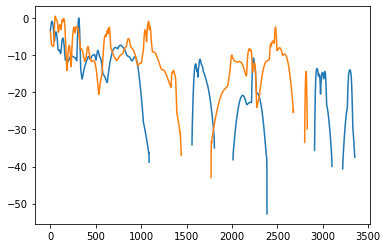

In [182]:
plt.plot(np.log10(gal_rolled[:3489]))
plt.plot(np.log10(np.flip(gal_rolled[3489:])))


In [204]:
max_od_SI = []
for i in range(91):
    galnum = i 
    gal_32 = gals12p5['gal_'+str(galnum)]['LOS_0'][pairs_elmts[2][0]][pairs_elmts[2][1]]['optical depth-weighted']['Optical depths'][...]
    
    max_od_SI.append(np.random.choice(gal_32))

In [236]:
np.log10(np.median(max_od_SI))

/cosma/home/dp004/dc-aram1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


-inf

In [107]:
np.argmin(np.abs(gals12p5['gal_'+str(galnum)]['LOS_0'].attrs['ProjectionStart'][0]*100-halos['pos_x']))

21

In [201]:
velocities = np.arange(len(gals12p5['gal_'+str(galnum)]['LOS_0'][pairs_elmts[2][0]][pairs_elmts[2][1]]['optical depth-weighted']['Optical depths'][...]))

In [229]:
b=20 / np.sqrt(opticaldepth[('Silicon', 'Si IV')]['Mass']/ constants['mH'])
v0 = 2895
gauss = np.exp(-(velocities-v0)**2/b**2)
tau0  = 4
line_siv = gauss * tau0

In [234]:
b=20 / np.sqrt(opticaldepth[('Carbon', 'C IV')]['Mass']/ constants['mH'])
v0 = 2895
gauss = np.exp(-(velocities-v0)**2/b**2)
tau0  = 500
line_civ = gauss * tau0

(2850.0, 2950.0)

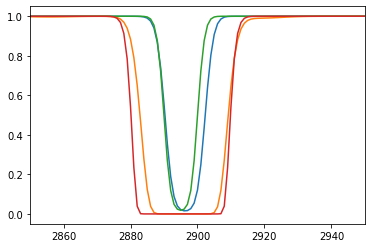

In [235]:
plt.plot(velocities,np.exp(-gals12p5['gal_'+str(galnum)]['LOS_0'][pairs_elmts[2][0]][pairs_elmts[2][1]]['optical depth-weighted']['Optical depths'][...]))
plt.plot(velocities,np.exp(-gals12p5['gal_'+str(galnum)]['LOS_0'][pairs_elmts[1][0]][pairs_elmts[1][1]]['optical depth-weighted']['Optical depths'][...]))
plt.plot(velocities,np.exp(-line_siv))
plt.plot(velocities,np.exp(-line_civ))

plt.xlim(2850,2950)

8


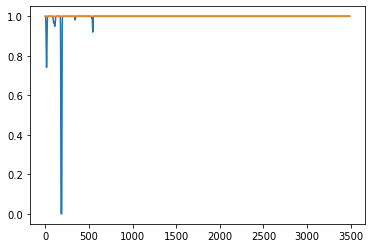

In [229]:
print(galnum)
plt.plot(np.exp(-gal_rolled[:3489]))
plt.plot(np.exp(-np.flip(gal_rolled[3489:])))


Now we define a structure where we are going to save all our galaxies. Each half of the sightline has a length of 3489 pixels, we have 91 galaxies from which we get two sight lines for 200 impact parameters. 

In [113]:
total_gal_contr = 182
halfsightline_size = 3489
number_b = 200


In [114]:
gal_structuren = np.zeros((total_gal_contr,halfsightline_size,number_b))

In [804]:
pairs_elmts = [('Hydrogen','H I'),('Carbon','C IV'),('Silicon','Si IV')]
elements, ions = pairs_elmts[1]

In [805]:
for galn in range(0,182,2):
    for i in range(200):
        try:
            gal =  gals12p5['gal_'+str(int(galn/2))]['LOS_'+str(i)][elements][ions]['optical depth-weighted']['Optical depths'][...]
            vel_infx_off = int(round(hubble_vel_gal[int(galn/2)]))#+get_vel_noise(i))
            gal_rolled = np.roll(gal,-vel_infx_off)
            firsthalf = gal_rolled[:3489]
            secondhalf = np.flip(gal_rolled[3489:])
            gal_structuren[galn,:,i] = firsthalf
            gal_structuren[galn+1,:,i] = secondhalf
        except: 
            print("problem in LOS # "+str(i), " in gal# "+str(int(galn/2)))
            gal_structuren[galn,:,i] = firsthalf
            gal_structuren[galn+1,:,i] = secondhalf


problem in LOS # 120  in gal# 39
problem in LOS # 151  in gal# 54


In [447]:
help(AO.Rebin)

Help on method Rebin in module SpecWizard_AnalyseOpticaldepth:

Rebin(spectrum, wave) method of SpecWizard_AnalyseOpticaldepth.Analyse_Opticaldepth instance
    rebin the function y(x) to the new bins xnew
    Interpolation is performed such that the mean of the function is conserved
    Input: 
      -spectrum: dictionary, containing
         -L:       linear extent of the wavelength range
         -wave:    wavelength or Hubble velocity
         -flux:    flux
      -wave:       new wavelenght or Hubble velocioty to rebin to



In [383]:
def get_gal_struture(fname = "all_gals_12p5_2p34_91_good.hdf5",pairs_elmts=('Hydrogen','H I'),vel_err=True,offsets = 0,convolve=False):
    
    elements, ions = pairs_elmts
    gals12p5 = h5py.File(fname,'r')
#gals12p5 = h5py.File("all_gals_12p5_2p34_91_hm01.hdf5",'r')
    halo_index = gals12p5['halo_index']
    
    total_gal_contr = 182
    halfsightline_size = 3489
    number_b = 200
    gal_structuren = np.zeros((total_gal_contr,halfsightline_size,number_b))
    
    
    
    half_los_pix = 3489
    half_Box_cMpc = 50
    b_num         = 200
    ylist = np.arange(half_los_pix) * (half_Box_cMpc*a_fact)/half_los_pix

    xbins_lin = dx_grid * a_fact#10**xlog#np.linspace(0,2,100)
    ybins_lin = ylist
    X, Y = np.meshgrid(xbins_lin,ybins_lin)
    
    vpec_z = np.array([ halos[halo_index[i]]['vel_z'] for i in range(0,91)])
    hubble_vel_gal = (snapshot.Hubble() * a_fact * (halos[halo_index]['pos_z']) * constants['Mpc'] / 1e5 )+ vpec_z
    
    for galn in range(0,182,2):
        for i in range(200):
            try:
                if vel_err:
                    vel_noise = get_vel_noise(i)
                else:
                    vel_noise = 0
                gal =  gals12p5['gal_'+str(int(galn/2))]['LOS_'+str(i)][elements][ions]['optical depth-weighted']['Optical depths'][...]
                if convolve:
                    intrumnt_flux = AO.Convolve(np.exp(-gal),8.5)
                    gal = -np.log(intrumnt_flux['flux'])
                vel_infx_off = int(round(hubble_vel_gal[int(galn/2)])+vel_noise)
                gal_rolled = np.roll(gal,-vel_infx_off)
                firsthalf = gal_rolled[:3489]
                secondhalf = np.flip(gal_rolled[3489:])
                gal_structuren[galn,:,i] = firsthalf
                gal_structuren[galn+1,:,i] = secondhalf
            except: 
                print("problem in LOS # "+str(i), " in gal# "+str(int(galn/2)))
                gal_structuren[galn,:,i] = firsthalf
                gal_structuren[galn+1,:,i] = secondhalf
            
     # clean nans   
    gal_structuren[np.isnan(gal_structuren)] = 0
     # Use min non-zero value instead of zeros
    gal_structuren[gal_structuren==0] = gal_structuren[gal_structuren>0].min()  
    
    gal_structuren += offsets  
    half_los_pix = 3489
    half_Box_cMpc = 50
    b_num         = 200
    
    ylist = np.arange(half_los_pix) * (half_Box_cMpc*a_fact)/half_los_pix
    
    bin_edges = np.array([0.04, 0.13, 0.18, 0.25, 0.36, 0.5,0.71, 1, 1.42, 2])
    
    npix_y = 13
    npix_x = 10
    
    ylog = np.logspace(np.log10(0.04),np.log10(ylist[1263]),npix_y)
    log_structure = np.zeros((npix_x-1,npix_y-1))
    
    
    for i,(xa,xb) in enumerate(zip(bin_edges[0:-1],bin_edges[1:])):
        xleft  = xa#10**xa 
        xright = xb#10**xb 

        for j,(ya,yb) in enumerate(zip(ylog[0:-1],ylog[1:])):
            yleft = ya#10**ya
            yright = yb#10**yb

            mask = (X>=xleft) & (X<=xright) & (Y>=yleft) & (Y<=yright) 
            mask = mask
            if np.sum(mask)>0:
                log_structure[i,j] = np.median(gal_structuren[:,mask])
    return log_structure

In [239]:
bin_edges

array([0.04      , 0.06177808, 0.09541329, 0.14736126, 0.22759241,
       0.35150557, 0.54288352, 0.8384576 , 1.29495761, 2.        ])

In [240]:
ylog

array([0.04      , 0.06037383, 0.09112498, 0.1375391 , 0.20759405,
       0.3133312 , 0.4729251 , 0.71380748, 1.07738226, 1.62614231,
       2.45441094, 3.70455466, 5.59145374])

In [55]:
carbon_structure_hm12 = get_gal_struture(fname='all_gals_12p5_2p34_91_good.hdf5',pairs_elmts=('Carbon','C IV'),vel_err=False)
silicon_structure_hm12 = get_gal_struture(fname='all_gals_12p5_2p34_91_good.hdf5',pairs_elmts=('Silicon','Si IV'),vel_err=False)
hydrogen_structure_hm12 = get_gal_struture(fname='all_gals_12p5_2p34_91_good.hdf5',pairs_elmts=('Hydrogen','H I'),vel_err=False)

problem in LOS # 120  in gal# 39
problem in LOS # 151  in gal# 54


In [60]:
carbon_structure_hm12_vel = get_gal_struture(fname='all_gals_12p5_2p34_91_good.hdf5',pairs_elmts=('Carbon','C IV'),vel_err=True)
silicon_structure_hm12_vel = get_gal_struture(fname='all_gals_12p5_2p34_91_good.hdf5',pairs_elmts=('Silicon','Si IV'),vel_err=True)
hydrogen_structure_hm12_vel = get_gal_struture(fname='all_gals_12p5_2p34_91_good.hdf5',pairs_elmts=('Hydrogen','H I'),vel_err=True)

problem in LOS # 120  in gal# 39
problem in LOS # 151  in gal# 54
problem in LOS # 120  in gal# 39
problem in LOS # 151  in gal# 54
problem in LOS # 120  in gal# 39
problem in LOS # 151  in gal# 54


In [332]:
carbon_structure_hm12_vel_conv = get_gal_struture(fname='all_gals_12p5_2p34_91_good.hdf5',pairs_elmts=('Carbon','C IV'),vel_err=True,convolve=True)
silicon_structure_hm12_vel_conv = get_gal_struture(fname='all_gals_12p5_2p34_91_good.hdf5',pairs_elmts=('Silicon','Si IV'),vel_err=True,convolve=True)
hydrogen_structure_hm12_vel_conv = get_gal_struture(fname='all_gals_12p5_2p34_91_good.hdf5',pairs_elmts=('Hydrogen','H I'),vel_err=True,convolve=True)

/cosma/home/dp004/dc-aram1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
/cosma/home/dp004/dc-aram1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log


problem in LOS # 120  in gal# 39
problem in LOS # 151  in gal# 54
problem in LOS # 120  in gal# 39
problem in LOS # 151  in gal# 54
problem in LOS # 120  in gal# 39
problem in LOS # 151  in gal# 54


In [61]:
carbon_structure_hm01 = get_gal_struture(fname='all_gals_12p5_2p34_91_hm01.hdf5',pairs_elmts=('Carbon','C IV'),vel_err=False)
silicon_structure_hm01 = get_gal_struture(fname='all_gals_12p5_2p34_91_hm01.hdf5',pairs_elmts=('Silicon','Si IV'),vel_err=False)
hydrogen_structure_hm01 = get_gal_struture(fname='all_gals_12p5_2p34_91_hm01.hdf5',pairs_elmts=('Hydrogen','H I'),vel_err=False)

problem in LOS # 125  in gal# 5
problem in LOS # 138  in gal# 89
problem in LOS # 177  in gal# 89
problem in LOS # 125  in gal# 5
problem in LOS # 138  in gal# 89
problem in LOS # 177  in gal# 89
problem in LOS # 125  in gal# 5
problem in LOS # 138  in gal# 89
problem in LOS # 177  in gal# 89


In [62]:
carbon_structure_hm01_vel = get_gal_struture(fname='all_gals_12p5_2p34_91_hm01.hdf5',pairs_elmts=('Carbon','C IV'),vel_err=True)
silicon_structure_hm01_vel = get_gal_struture(fname='all_gals_12p5_2p34_91_hm01.hdf5',pairs_elmts=('Silicon','Si IV'),vel_err=True)
hydrogen_structure_hm01_vel = get_gal_struture(fname='all_gals_12p5_2p34_91_hm01.hdf5',pairs_elmts=('Hydrogen','H I'),vel_err=True)

problem in LOS # 125  in gal# 5
problem in LOS # 138  in gal# 89
problem in LOS # 177  in gal# 89
problem in LOS # 125  in gal# 5
problem in LOS # 138  in gal# 89
problem in LOS # 177  in gal# 89
problem in LOS # 125  in gal# 5
problem in LOS # 138  in gal# 89
problem in LOS # 177  in gal# 89


In [331]:
carbon_structure_hm01_vel_conv = get_gal_struture(fname='all_gals_12p5_2p34_91_hm01.hdf5',pairs_elmts=('Carbon','C IV'),vel_err=True,convolve=True)
silicon_structure_hm01_vel_conv = get_gal_struture(fname='all_gals_12p5_2p34_91_hm01.hdf5',pairs_elmts=('Silicon','Si IV'),vel_err=True,convolve=True)
hydrogen_structure_hm01_vel_conv = get_gal_struture(fname='all_gals_12p5_2p34_91_hm01.hdf5',pairs_elmts=('Hydrogen','H I'),vel_err=True,convolve=True)

problem in LOS # 125  in gal# 5


/cosma/home/dp004/dc-aram1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log


problem in LOS # 138  in gal# 89
problem in LOS # 177  in gal# 89
problem in LOS # 125  in gal# 5
problem in LOS # 138  in gal# 89
problem in LOS # 177  in gal# 89


/cosma/home/dp004/dc-aram1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log


problem in LOS # 125  in gal# 5
problem in LOS # 138  in gal# 89
problem in LOS # 177  in gal# 89


In [808]:
gal_structuren[gal_structuren==0] =1.1190413622530724e-59

In [809]:
gal_structuren_silicon = gal_structuren

In [810]:
gal_structuren_carbon = gal_structuren

In [42]:
half_los_pix = 3489
half_Box_cMpc = 50
b_num         = 200

In [43]:
ylist = np.arange(half_los_pix) * (half_Box_cMpc*a_fact)/half_los_pix

In [44]:

ylist = np.arange(half_los_pix) * (half_Box_cMpc*a_fact)/half_los_pix

xbins_lin = dx_grid * a_fact#10**xlog#np.linspace(0,2,100)
ybins_lin = ylist
X, Y = np.meshgrid(xbins_lin,ybins_lin)

In [238]:
bin_edges

array([0.04      , 0.06177808, 0.09541329, 0.14736126, 0.22759241,
       0.35150557, 0.54288352, 0.8384576 , 1.29495761, 2.        ])

In [45]:
bin_edges = np.array([0.04, 0.13, 0.18, 0.25, 0.36, 0.5,0.71, 1, 1.42, 2])

In [824]:
10/0.8

12.5

In [67]:
npix_y = 13
npix_x = 10

In [68]:
bin_edges = np.logspace(np.log10(0.04),np.log10(2),npix_x)

In [69]:
ylog = np.logspace(np.log10(0.04),np.log10(ylist[1263]),npix_y)

In [837]:
log_structure = np.zeros((npix_x-1,npix_y-1))

In [819]:
for i,(xa,xb) in enumerate(zip(bin_edges[0:-1],bin_edges[1:])):
    xleft  = xa#10**xa 
    xright = xb#10**xb 

    for j,(ya,yb) in enumerate(zip(ylog[0:-1],ylog[1:])):
        yleft = ya#10**ya
        yright = yb#10**yb
        
        mask = (X>=xleft) & (X<=xright) & (Y>=yleft) & (Y<=yright) 
        mask = mask
        if np.sum(mask)>0:
            log_structure[i,j] = np.median(gal_structuren_carbon[:,mask])

In [70]:
log_structure_silicon = log_structure

NameError: name 'log_structure' is not defined

In [821]:
log_structure_carbon  = log_structure

In [71]:
bin_centers_x = 0.5*(bin_edges[1:]+bin_edges[:-1])
bin_centers_y  = 0.5*(ylog[1:]+ylog[:-1])

In [72]:
bin_centers_x

array([0.05088904, 0.07859569, 0.12138728, 0.18747683, 0.28954899,
       0.44719455, 0.69067056, 1.0667076 , 1.6474788 ])

In [73]:
y_bin_kms = bin_centers_y * snapshot.Hubble() * (constants['Mpc']/1e5)

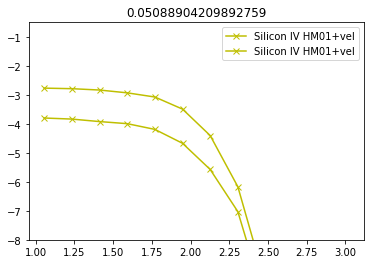

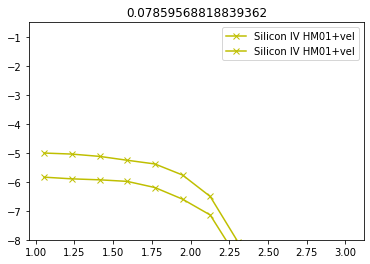

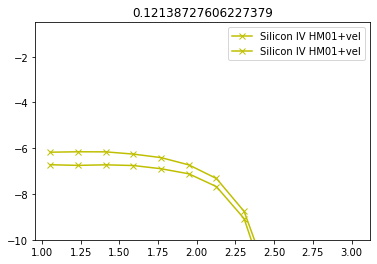

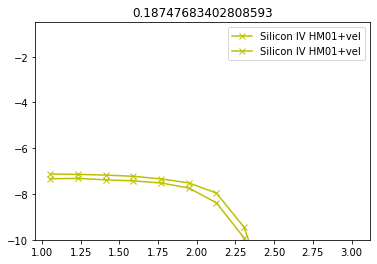

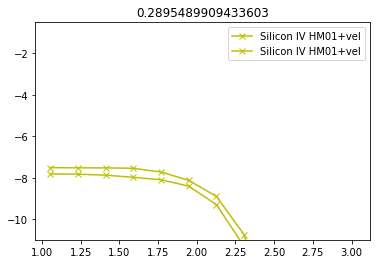

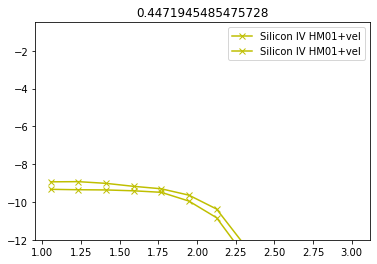

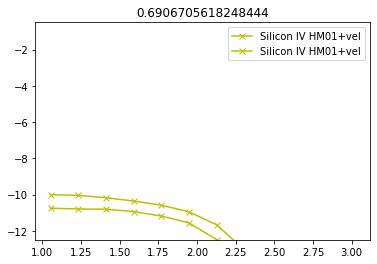

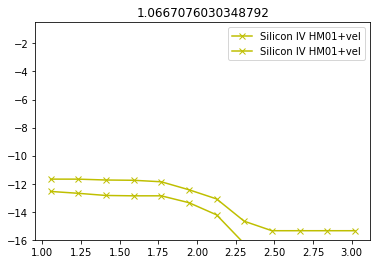

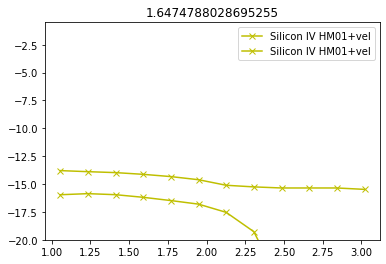

In [329]:
llevels = [-8,-8,-10,-10,-11,-12,-12.5,-16,-20]
for i in range(9):
    plt.title(str(bin_centers_x[i]))
    plt.plot(np.log10(y_bin_kms),np.log10(silicon_structure_hm01_vel[i,:]),'-x',c='y',label='Silicon IV HM01+vel')
    plt.plot(np.log10(y_bin_kms),np.log10(silicon_structure_hm01_vel_conv[i,:]),'-x',c='y',label='Silicon IV HM01+vel')


    plt.legend()
    #plt.xscale('log')
    #plt.xlim(0.04,1)
    plt.ylim(llevels[i],-0.5)
    plt.show()

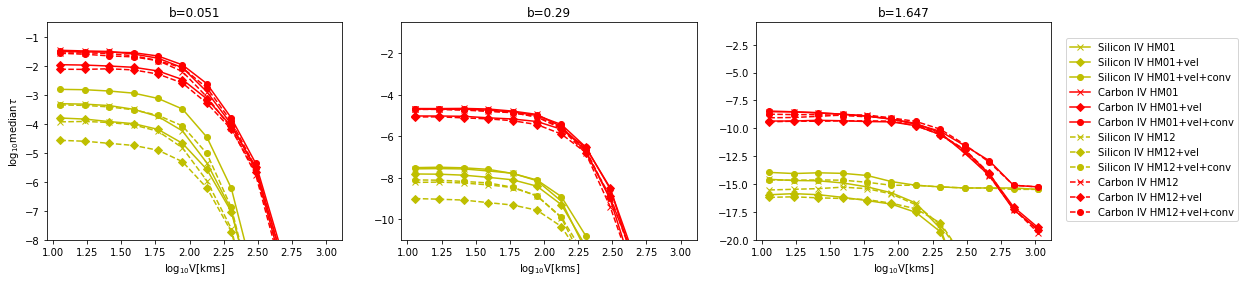

In [431]:
fig, axs = plt.subplots(1, 3,figsize=(18, 4))

for j,i in enumerate(np.array([0,4,8])):
    ax = axs[j]
    ax.set_title("b="+str(round(bin_centers_x[i],3)))
    ax.plot(np.log10(y_bin_kms),np.log10(silicon_structure_hm01[i,:]),'-x',c='y',label='Silicon IV HM01')
    ax.plot(np.log10(y_bin_kms),np.log10(silicon_structure_hm01_vel[i,:]),'-D',c='y',label='Silicon IV HM01+vel')
    ax.plot(np.log10(y_bin_kms),np.log10(silicon_structure_hm01_vel_conv[i,:]),'-o',c='y',label='Silicon IV HM01+vel+conv')

    ax.plot(np.log10(y_bin_kms),np.log10(carbon_structure_hm01[i,:]),'-x',c='r',label='Carbon IV HM01')
    ax.plot(np.log10(y_bin_kms),np.log10(carbon_structure_hm01_vel[i,:]),'-D',c='r',label='Carbon IV HM01+vel')
    ax.plot(np.log10(y_bin_kms),np.log10(carbon_structure_hm01_vel_conv[i,:]),'-o',c='r',label='Carbon IV HM01+vel+conv')

    
    ax.plot(np.log10(y_bin_kms),np.log10(silicon_structure_hm12[i,:]),'--x',c='y',label='Silicon IV HM12')
    ax.plot(np.log10(y_bin_kms),np.log10(silicon_structure_hm12_vel[i,:]),'--D',c='y',label='Silicon IV HM12+vel')
    ax.plot(np.log10(y_bin_kms),np.log10(silicon_structure_hm12_vel_conv[i,:]),'--o',c='y',label='Silicon IV HM12+vel+conv')

    ax.plot(np.log10(y_bin_kms),np.log10(carbon_structure_hm12[i,:]),'--x',c='r',label='Carbon IV HM12')
    ax.plot(np.log10(y_bin_kms),np.log10(carbon_structure_hm12_vel[i,:]),'--D',c='r',label='Carbon IV HM12+vel')
    ax.plot(np.log10(y_bin_kms),np.log10(carbon_structure_hm12_vel_conv[i,:]),'--o',c='r',label='Carbon IV HM12+vel+conv')
    if j==0:
        
        ax.set_ylabel(r'$\log_{10} \mathrm{median} \tau$')
    ax.set_xlabel(r'$\log_{10} \mathrm{V[kms]}$')
    #plt.xscale('log')
    #plt.xlim(0.04,1)
    ax.set_ylim(llevels[i],-0.5)
plt.legend(bbox_to_anchor=(1.65, 0.95), loc="upper right")
plt.savefig("impactparameter_conv.pdf",dpi=300,bbox_inches='tight')

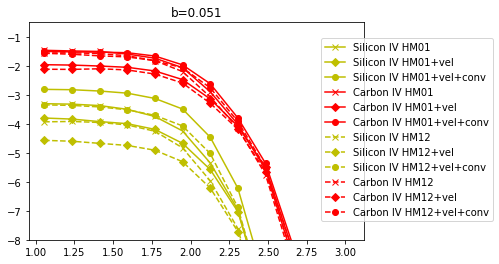

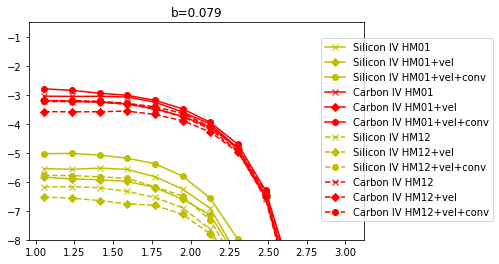

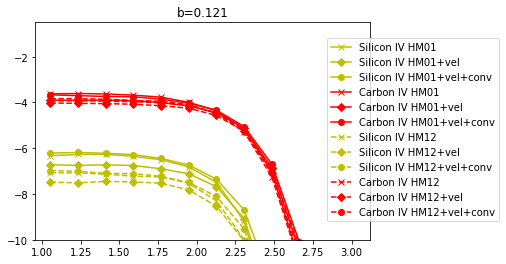

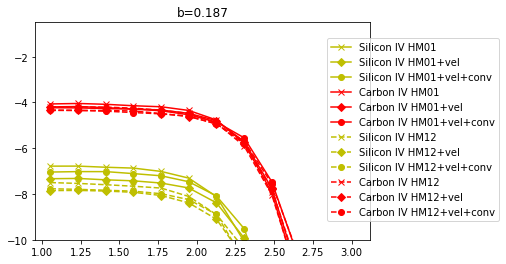

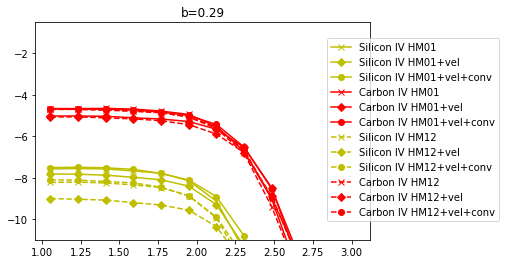

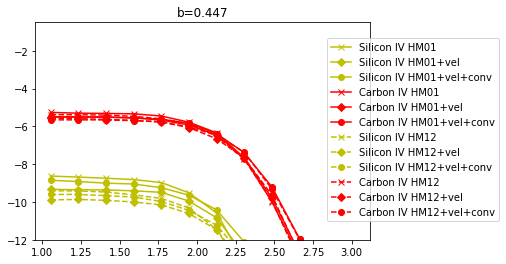

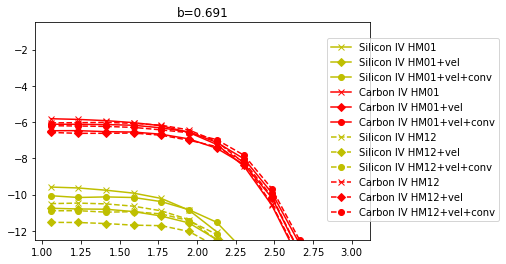

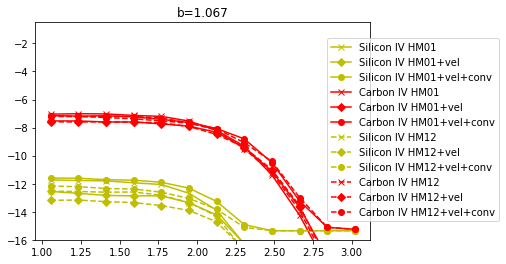

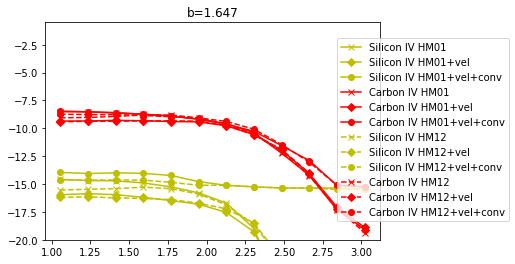

In [384]:
llevels = [-8,-8,-10,-10,-11,-12,-12.5,-16,-20]
for i in range(9):
    plt.title("b="+str(round(bin_centers_x[i],3)))
    plt.plot(np.log10(y_bin_kms),np.log10(silicon_structure_hm01[i,:]),'-x',c='y',label='Silicon IV HM01')
    plt.plot(np.log10(y_bin_kms),np.log10(silicon_structure_hm01_vel[i,:]),'-D',c='y',label='Silicon IV HM01+vel')
    plt.plot(np.log10(y_bin_kms),np.log10(silicon_structure_hm01_vel_conv[i,:]),'-o',c='y',label='Silicon IV HM01+vel+conv')

    plt.plot(np.log10(y_bin_kms),np.log10(carbon_structure_hm01[i,:]),'-x',c='r',label='Carbon IV HM01')
    plt.plot(np.log10(y_bin_kms),np.log10(carbon_structure_hm01_vel[i,:]),'-D',c='r',label='Carbon IV HM01+vel')
    plt.plot(np.log10(y_bin_kms),np.log10(carbon_structure_hm01_vel_conv[i,:]),'-o',c='r',label='Carbon IV HM01+vel+conv')

    
    plt.plot(np.log10(y_bin_kms),np.log10(silicon_structure_hm12[i,:]),'--x',c='y',label='Silicon IV HM12')
    plt.plot(np.log10(y_bin_kms),np.log10(silicon_structure_hm12_vel[i,:]),'--D',c='y',label='Silicon IV HM12+vel')
    plt.plot(np.log10(y_bin_kms),np.log10(silicon_structure_hm12_vel_conv[i,:]),'--o',c='y',label='Silicon IV HM12+vel+conv')

    plt.plot(np.log10(y_bin_kms),np.log10(carbon_structure_hm12[i,:]),'--x',c='r',label='Carbon IV HM12')
    plt.plot(np.log10(y_bin_kms),np.log10(carbon_structure_hm12_vel[i,:]),'--D',c='r',label='Carbon IV HM12+vel')
    plt.plot(np.log10(y_bin_kms),np.log10(carbon_structure_hm12_vel_conv[i,:]),'--o',c='r',label='Carbon IV HM12+vel+conv')

    plt.xlabel()
    plt.legend(bbox_to_anchor=(1.4, 0.95), loc="upper right")
    #plt.xscale('log')
    #plt.xlim(0.04,1)
    plt.ylim(llevels[i],-0.5)
    plt.show()

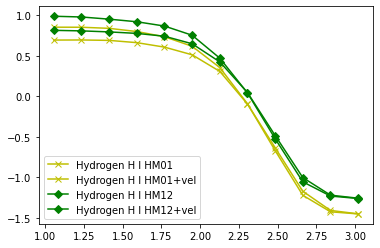

In [176]:
plt.plot(np.log10(y_bin_kms),np.log10(Hydrogen_structure_hm01[0,:]),'-x',c='y',label='Hydrogen H I HM01')
plt.plot(np.log10(y_bin_kms),np.log10(Hydrogen_structure_hm01_vel[0,:]),'-x',c='y',label='Hydrogen H I HM01+vel')

plt.plot(np.log10(y_bin_kms),np.log10(Hydrogen_structure_hm12[0,:]),'-D',c='g',label='Hydrogen H I HM12')
plt.plot(np.log10(y_bin_kms),np.log10(Hydrogen_structure_hm12_vel[0,:]),'-D',c='g',label='Hydrogen H I HM12+vel')

plt.legend()


In [ ]:
for col in range(2):
    for row in range(2):
        ax = axs[row, col]
        pcm = ax.pcolormesh(np.random.random((20, 20)) * (col + 1),
                            cmap=cmaps[col])
        fig.colorbar(pcm, ax=ax)

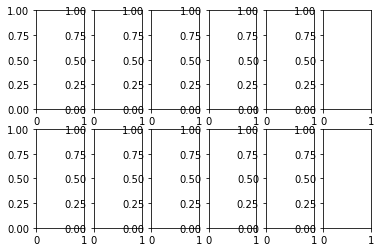

In [177]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)

fig, axs = plt.subplots(2, 6)

In [179]:
np.shape(Hydrogen_structure_hm01)

(9, 12)

In [344]:
all_structure = np.zeros((2,9,9,12))

In [345]:
all_structure[0,0,:,:] = hydrogen_structure_hm12 
all_structure[0,1,:,:] = hydrogen_structure_hm12_vel
all_structure[0,2,:,:] = hydrogen_structure_hm12_vel_conv

all_structure[0,3,:,:] = carbon_structure_hm12 
all_structure[0,4,:,:] = carbon_structure_hm12_vel
all_structure[0,5,:,:] = carbon_structure_hm12_vel_conv

all_structure[0,6,:,:] = silicon_structure_hm12 
all_structure[0,7,:,:] = silicon_structure_hm12_vel
all_structure[0,8,:,:] = silicon_structure_hm12_vel_conv

all_structure[1,0,:,:] = hydrogen_structure_hm01 
all_structure[1,1,:,:] = hydrogen_structure_hm01_vel
all_structure[1,2,:,:] = hydrogen_structure_hm01_vel_conv

all_structure[1,3,:,:] = carbon_structure_hm01 
all_structure[1,4,:,:] = carbon_structure_hm01_vel
all_structure[1,5,:,:] = carbon_structure_hm01_vel_conv

all_structure[1,6,:,:] = silicon_structure_hm01 
all_structure[1,7,:,:] = silicon_structure_hm01_vel
all_structure[1,8,:,:] = silicon_structure_hm01_vel_conv


In [432]:
level_edges = [[-1.3,0.7],[-1.3,0.7],[-1.3,0.7],[-6,-1.9],[-6,-1.9],[-6,-1.9],[-8.5,-2.5],[-8.5,-2.5],[-8.5,-2.5]] 

In [378]:
level_edges = [[-1.3,0.7],[-1.3,0.7],[-1.3,0.7],[-5,-1.5],[-5,-1.5],[-5,-1.5],[-6,-3.2],[-6,-3.2],[-6,-3.2]] 

In [361]:
labeldic = {0:"H I",3:"C IV",6:"Si IV"}

In [442]:
np.log10((10**(-3.2)-10**(-4.4)))

-3.22830478378312

In [446]:
np.log10(10**-2.9+10**-3.22830478378312)

-2.7328113604477062

/cosma/home/dp004/dc-aram1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: The following kwargs were not used by contour: 'negative_linestyles'


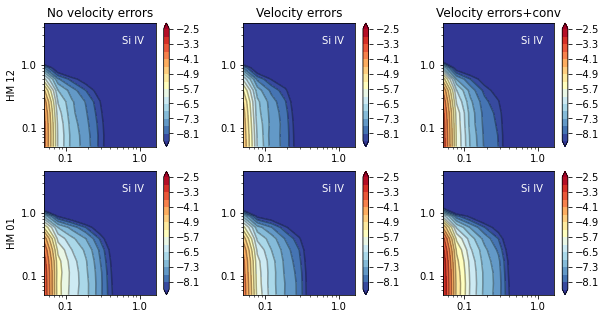

In [437]:
cmap='RdYlBu_r'
selector = 6
fig, axs = plt.subplots(2, 3,figsize=(10, 5))
for i in range(2):
    for j in range(3):
        llow,lhigh = level_edges[j+selector]
        levels = np.linspace(llow,lhigh,16)
        ax = axs[i, j]
        if i==0 and j==0:
            ax.title.set_text('No velocity errors')
            ax.set_ylabel("HM 12")
        if i==0 and j==1:
            ax.title.set_text('Velocity errors')
        if i==0 and j==2:
            ax.title.set_text('Velocity errors+conv')
            
        if i==1 and j==0:
            ax.set_ylabel("HM 01")
            
        ax.contour(bin_centers_x, bin_centers_y, np.log10(all_structure[i,j+selector,:,:]).T,levels=levels,extend='both',colors='black',alpha=0.35,linestyles='solid',negative_linestyles='solid'),#vmin=-1.2,vmax=0.7)
        im = ax.contourf(bin_centers_x,bin_centers_y, np.log10(all_structure[i,j+selector,:,:]).T,cmap=cmap,levels = levels,extend='both')#,vmin=-1.2,vmax=0.7)
        ax.text(0.8, 0.9,labeldic[selector],c="white",horizontalalignment='center', verticalalignment='top', transform=ax.transAxes)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xticks([0.1, 1])
        fig.colorbar(im, ax=ax)
        ax.set_yticks([0.1 ,1])
        ax.set_aspect(0.85)
        ax.xaxis.set_major_formatter(ScalarFormatter())
        ax.yaxis.set_major_formatter(ScalarFormatter())
plt.subplots_adjust(wspace=0.25, hspace=0.2)
plt.savefig("HM12andHM01compar"+labeldic[selector].replace(" ","")+".pdf",dpi=300,bbox_inches='tight')
#fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

/cosma/home/dp004/dc-aram1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: The following kwargs were not used by contour: 'negative_linestyles'
  """


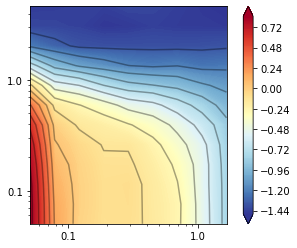

In [178]:
cmap='RdYlBu_r'

levels = np.linspace(-3.8,-2.4,16)
levels =  np.linspace(-1.5,0.80,16)
plt.contour(bin_centers_x, bin_centers_y, np.log10(Hydrogen_structure_hm01).T,levels=levels,extend='both',colors='black',alpha=0.35,linestyles='solid',negative_linestyles='solid'),#vmin=-1.2,vmax=0.7)
plt.contourf(bin_centers_x,bin_centers_y, np.log10(Hydrogen_structure_hm01).T,cmap=cmap,levels = 256,extend='both')#,vmin=-1.2,vmax=0.7)


# Step 5: Set logarithmic scale for x and y axes
plt.xscale('log')
plt.yscale('log')
plt.xticks([0.1, 1])

plt.yticks([0.1 ,1])
plt.gca().set_aspect(0.85)
plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
#plt.grid(which="both", linewidth=0.72,color="k")
cbar = plt.colorbar()
#cbar.set_clim()
# Display the plot
plt.show()

/cosma/home/dp004/dc-aram1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: The following kwargs were not used by contour: 'negative_linestyles'
  """


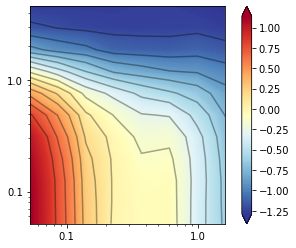

In [761]:
cmap='RdYlBu_r'

levels = np.linspace(-3.8,-2.4,16)
levels =  np.linspace(-1.5,0.80,16)
plt.contour(bin_centers_x, bin_centers_y, np.log10(log_structure).T,levels=levels,extend='both',colors='black',alpha=0.35,linestyles='solid',negative_linestyles='solid'),#vmin=-1.2,vmax=0.7)
plt.contourf(bin_centers_x,bin_centers_y, np.log10(log_structure).T,cmap=cmap,levels = 256,extend='both')#,vmin=-1.2,vmax=0.7)


# Step 5: Set logarithmic scale for x and y axes
plt.xscale('log')
plt.yscale('log')
plt.xticks([0.1, 1])

plt.yticks([0.1 ,1])
plt.gca().set_aspect(0.85)
plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
#plt.grid(which="both", linewidth=0.72,color="k")
cbar = plt.colorbar()
#cbar.set_clim()
# Display the plot
plt.show()

/cosma/home/dp004/dc-aram1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: The following kwargs were not used by contour: 'negative_linestyles'
  """


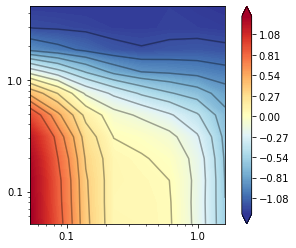

In [311]:
cmap='RdYlBu_r'

levels = np.linspace(-3.8,-2.4,16)
levels =  np.linspace(-1.5,0.80,16)
plt.contour(bin_centers_x, bin_centers_y, np.log10(log_structure).T,levels=levels,extend='both',colors='black',alpha=0.35,linestyles='solid',negative_linestyles='solid'),#vmin=-1.2,vmax=0.7)
plt.contourf(bin_centers_x,bin_centers_y, np.log10(log_structure).T,cmap=cmap,levels = 256,extend='both')#,vmin=-1.2,vmax=0.7)


# Step 5: Set logarithmic scale for x and y axes
plt.xscale('log')
plt.yscale('log')
plt.xticks([0.1, 1])

plt.yticks([0.1 ,1])
plt.gca().set_aspect(0.85)
plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
#plt.grid(which="both", linewidth=0.72,color="k")
cbar = plt.colorbar()
#cbar.set_clim()
# Display the plot
plt.show()

/cosma/home/dp004/dc-aram1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: The following kwargs were not used by contour: 'negative_linestyles'
  """


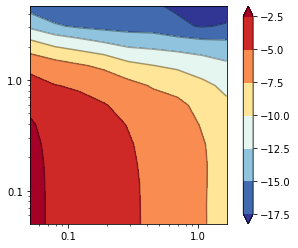

In [128]:
cmap='RdYlBu_r'

#levels = np.linspace(-4.0,-1.0,16)
#levels =  np.linspace(-1.5,0.80,16)
plt.contour(bin_centers_x, bin_centers_y, np.log10(carbon_structure_hm12).T,extend='both',colors='black',alpha=0.35,linestyles='solid',negative_linestyles='solid'),#vmin=-1.2,vmax=0.7)
plt.contourf(bin_centers_x,bin_centers_y, np.log10(carbon_structure_hm12).T,cmap=cmap,extend='both')#,vmin=-1.2,vmax=0.7)


# Step 5: Set logarithmic scale for x and y axes
plt.xscale('log')
plt.yscale('log')
plt.xticks([0.1, 1])
plt.yticks([0.1 ,1])
plt.gca().set_aspect(0.85)
plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
#plt.grid(which="both", linewidth=0.72,color="k")
cbar = plt.colorbar()
#cbar.set_clim()
# Display the plot
plt.show()

/cosma/home/dp004/dc-aram1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: The following kwargs were not used by contour: 'negative_linestyles'
  """


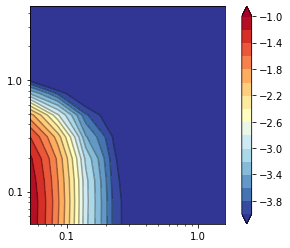

In [793]:
cmap='RdYlBu_r'

levels = np.linspace(-4.0,-1.0,16)
#levels =  np.linspace(-1.5,0.80,16)
plt.contour(bin_centers_x, bin_centers_y, np.log10(log_structure).T,levels=levels,extend='both',colors='black',alpha=0.35,linestyles='solid',negative_linestyles='solid'),#vmin=-1.2,vmax=0.7)
plt.contourf(bin_centers_x,bin_centers_y, np.log10(log_structure).T,cmap=cmap,levels = levels,extend='both')#,vmin=-1.2,vmax=0.7)


# Step 5: Set logarithmic scale for x and y axes
plt.xscale('log')
plt.yscale('log')
plt.xticks([0.1, 1])
plt.yticks([0.1 ,1])
plt.gca().set_aspect(0.85)
plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
#plt.grid(which="both", linewidth=0.72,color="k")
cbar = plt.colorbar()
#cbar.set_clim()
# Display the plot
plt.show()

/cosma/home/dp004/dc-aram1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: The following kwargs were not used by contour: 'negative_linestyles'
  """


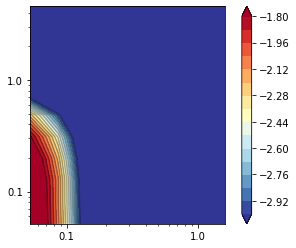

In [739]:
cmap='RdYlBu_r'

levels = np.linspace(-3.0,-1.8,16)
#levels =  np.linspace(-1.5,0.80,16)
plt.contour(bin_centers_x, bin_centers_y, np.log10(log_structure).T,levels=levels,extend='both',colors='black',alpha=0.35,linestyles='solid',negative_linestyles='solid'),#vmin=-1.2,vmax=0.7)
plt.contourf(bin_centers_x,bin_centers_y, np.log10(log_structure).T,cmap=cmap,levels = levels,extend='both')#,vmin=-1.2,vmax=0.7)


# Step 5: Set logarithmic scale for x and y axes
plt.xscale('log')
plt.yscale('log')
plt.xticks([0.1, 1])
plt.yticks([0.1 ,1])
plt.gca().set_aspect(0.85)
plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
#plt.grid(which="both", linewidth=0.72,color="k")
cbar = plt.colorbar()
#cbar.set_clim()
# Display the plot
plt.show()

In [236]:
ylist = np.arange(3489) * (50*a_fact)/3489
xbins_lin = dx_grid * a_fact#10**xlog#np.linspace(0,2,100)
ybins_lin = ylist
X, Y = np.meshgrid(xbins_lin,ybins_lin)

In [243]:
npix_y = 20*2
npix_x = 16*2
log_structure = np.zeros((npix_x,npix_y))

In [242]:
bin_edges = np.logspace(np.log10(0.04),np.log10(2),npix_x)
ylog = np.logspace(np.log10(0.04),np.log10(ylist[-1]),npix_y)

In [ ]:
for i,(xa,xb) in enumerate(zip(bin_edges[0:-1],bin_edges[1:])):
    xleft  = xa#10**xa 
    xright = xb#10**xb 

    for j,(ya,yb) in enumerate(zip(ylog[0:-1],ylog[1:])):
        yleft = ya#10**ya
        yright = yb#10**yb
        
        mask = (X>=xleft) & (X<=xright) & (Y>=yleft) & (Y<=yright) 
        mask = mask
        if np.sum(mask)>0:
            log_structure[i,j] = np.median(gal_structuren[:,mask])

In [244]:
bleh = np.median(gal_structuren,axis=0)

In [257]:
np.shape(bleh)

(3489, 200)

In [255]:
bleh_log = np.zeros((250,200))

In [256]:
ylog = np.logspace(np.log10(0.04),np.log10(ylist[-1]),250)

In [258]:
for i in range(200):
    for j,(ya,yb) in enumerate(zip(ylog[0:-1],ylog[1:])):
        yleft = ya#10**ya
        yright = yb#10**yb
        jmas = np.where((yleft<=ylist) & (yright>=ylist))[0]
        bleh_log[j,i] = np.median(bleh[jmas,i])

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/cosma/local/Python/3.6.5/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/cosma/home/dp004/dc-aram1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


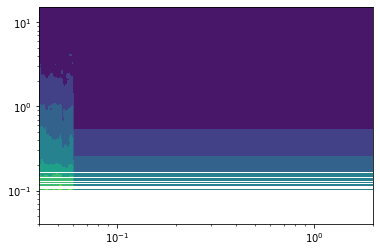

In [264]:
plt.contourf(xbins_lin,ylog,np.log10(bleh_log),origin='lower')
plt.xscale('log')
plt.yscale('log')

In [1138]:
gal_los = gals12p5['gal_0']['LOS_4']['Hydrogen']['H I']['optical depth-weighted']['Optical depths'][...]
len_of_extended = len(gal_los)
len_of_actual_los = len_of_extended/10
start_indx = int((len_of_extended - len_of_actual_los) * 0.5)
end_indx  = int((start_indx + len_of_actual_los*0.5))+1

In [1880]:
npix_x   = 24 
npix_y   = 30
xmin    = 0.04 
xmax    = 2.0
ymin    = 0.04 
ymax    = 16.06

In [ ]:
for i,(xa,xb) in enumerate(zip(bin_edges_extend[0:-1],bin_edges_extend[1:])):
    xleft  = xa#10**xa 
    xright = xb#10**xb 

    for j,(ya,yb) in enumerate(zip(ylog[0:-1],ylog[1:])):
        yleft = ya#10**ya
        yright = yb#10**yb
        
        mask = (X>=xleft) & (X<=xright) & (Y>=yleft) & (Y<=yright) 

        if np.sum(mask)>0:
            print(np.median(structure3d[:,mask]))
            log_structure[i,j] = np.median(structure3d[:,mask])

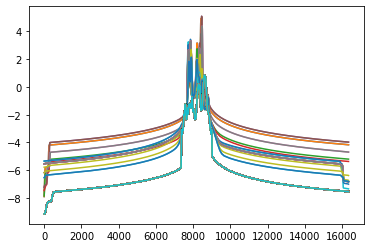

In [1182]:
for i in range(200):
    plt.plot(np.log10(gals12p5['gal_0']['LOS_'+str(i)]['Hydrogen']['H I']['optical depth-weighted']['Optical depths'][...]))

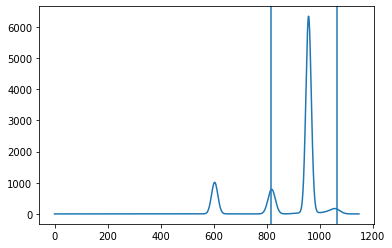

In [1228]:
plt.plot(gals12p5['gal_80']['LOS_0']['Hydrogen']['H I']['optical depth-weighted']['Optical depths'][...][start_indx:8506])
plt.axvline(x=8422-start_indx)
plt.axvline(x=8175-start_indx)


In [1194]:
np.argmax(gals12p5['gal_0']['LOS_0']['Hydrogen']['H I']['optical depth-weighted']['Optical depths'][...])

8422

In [1184]:
end_indx

8175

In [1490]:
num_galaxies = 100
num_los = 200
num_of_pixels = 817#end_indx-start_indx-1

In [1762]:
num_of_pixels

817

In [1491]:
structure3d = np.zeros([num_galaxies,num_of_pixels,num_los])

In [1143]:
center_indx = int(np.median(np.arange(len(actual_los))))

In [1144]:
center = actual_los[center_indx]


In [926]:
indx_edges = np.linspace(0,817+1,126).astype(int)
indx_edges_left = indx_edges[:-1]
indx_edges_right = indx_edges[1:]

In [1761]:
start_indx-end_indx

-844

In [1492]:
for i in range(100):
    for j in range(200):
        try:
            if j==0:
                central_pixel = np.argmax(gals12p5['gal_'+str(i)]['LOS_'+str(j)]['Hydrogen']['H I']['optical depth-weighted']['Optical depths'][...])
                start_indx   = central_pixel-817
            actual_los = gals12p5['gal_'+str(i)]['LOS_'+str(j)]['Hydrogen']['H I']['optical depth-weighted']['Optical depths'][start_indx:central_pixel]
            structure3d[i,:,j] = np.flip(actual_los) # we flip the los so the zero is the highest point like turner plot 
        except:
            print("problem with gal#",i, " and LOS#", j)
            structure3d[i,:,j] = np.zeros_like(actual_los)

problem with gal# 22  and LOS# 18
problem with gal# 22  and LOS# 19


In [1495]:
np.shape(structure3d)

(100, 817, 200)

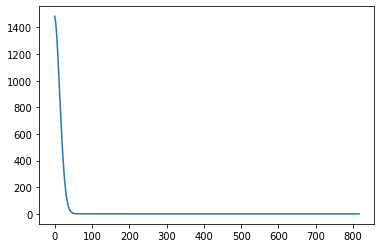

In [1501]:
#plt.plot(structure3d[10,199,:])
plt.plot(structure3d[69,:,0])

In [1252]:
len(structure3d[10,0,:])

817

In [1166]:
xbins_lin

array([0.04      , 0.04079415, 0.04160406, 0.04243005, 0.04327244,
       0.04413156, 0.04500773, 0.0459013 , 0.0468126 , 0.047742  ,
       0.04868986, 0.04965653, 0.05064239, 0.05164783, 0.05267322,
       0.05371898, 0.0547855 , 0.05587319, 0.05698247, 0.05811378,
       0.05926755, 0.06044423, 0.06164427, 0.06286813, 0.06411629,
       0.06538924, 0.06668745, 0.06801144, 0.06936171, 0.0707388 ,
       0.07214322, 0.07357552, 0.07503627, 0.07652601, 0.07804533,
       0.07959481, 0.08117506, 0.08278668, 0.0844303 , 0.08610655,
       0.08781608, 0.08955954, 0.09133763, 0.09315101, 0.0950004 ,
       0.0968865 , 0.09881005, 0.10077179, 0.10277248, 0.10481289,
       0.1068938 , 0.10901604, 0.1111804 , 0.11338774, 0.1156389 ,
       0.11793475, 0.12027618, 0.1226641 , 0.12509943, 0.12758311,
       0.1301161 , 0.13269938, 0.13533395, 0.13802082, 0.14076103,
       0.14355565, 0.14640576, 0.14931244, 0.15227684, 0.15530009,
       0.15838336, 0.16152785, 0.16473476, 0.16800535, 0.17134

In [1369]:
np.log10(lin_bins)

array([-1.39794001, -1.38940216, -1.38086431, -1.37232646, -1.36378861,
       -1.35525075, -1.3467129 , -1.33817505, -1.3296372 , -1.32109935,
       -1.3125615 , -1.30402365, -1.2954858 , -1.28694795, -1.2784101 ,
       -1.26987225, -1.26133439, -1.25279654, -1.24425869, -1.23572084,
       -1.22718299, -1.21864514, -1.21010729, -1.20156944, -1.19303159,
       -1.18449374, -1.17595589, -1.16741803, -1.15888018, -1.15034233,
       -1.14180448, -1.13326663, -1.12472878, -1.11619093, -1.10765308,
       -1.09911523, -1.09057738, -1.08203953, -1.07350168, -1.06496382,
       -1.05642597, -1.04788812, -1.03935027, -1.03081242, -1.02227457,
       -1.01373672, -1.00519887, -0.99666102, -0.98812317, -0.97958532,
       -0.97104746, -0.96250961, -0.95397176, -0.94543391, -0.93689606,
       -0.92835821, -0.91982036, -0.91128251, -0.90274466, -0.89420681,
       -0.88566896, -0.8771311 , -0.86859325, -0.8600554 , -0.85151755,
       -0.8429797 , -0.83444185, -0.825904  , -0.81736615, -0.80

In [1444]:
lin_bins

array([0.04      , 0.04079415, 0.04160406, 0.04243005, 0.04327244,
       0.04413156, 0.04500773, 0.0459013 , 0.0468126 , 0.047742  ,
       0.04868986, 0.04965653, 0.05064239, 0.05164783, 0.05267322,
       0.05371898, 0.0547855 , 0.05587319, 0.05698247, 0.05811378,
       0.05926755, 0.06044423, 0.06164427, 0.06286813, 0.06411629,
       0.06538924, 0.06668745, 0.06801144, 0.06936171, 0.0707388 ,
       0.07214322, 0.07357552, 0.07503627, 0.07652601, 0.07804533,
       0.07959481, 0.08117506, 0.08278668, 0.0844303 , 0.08610655,
       0.08781608, 0.08955954, 0.09133763, 0.09315101, 0.0950004 ,
       0.0968865 , 0.09881005, 0.10077179, 0.10277248, 0.10481289,
       0.1068938 , 0.10901604, 0.1111804 , 0.11338774, 0.1156389 ,
       0.11793475, 0.12027618, 0.1226641 , 0.12509943, 0.12758311,
       0.1301161 , 0.13269938, 0.13533395, 0.13802082, 0.14076103,
       0.14355565, 0.14640576, 0.14931244, 0.15227684, 0.15530009,
       0.15838336, 0.16152785, 0.16473476, 0.16800535, 0.17134

In [1551]:
lin_bins

array([0.04      , 0.04079415, 0.04160406, 0.04243005, 0.04327244,
       0.04413156, 0.04500773, 0.0459013 , 0.0468126 , 0.047742  ,
       0.04868986, 0.04965653, 0.05064239, 0.05164783, 0.05267322,
       0.05371898, 0.0547855 , 0.05587319, 0.05698247, 0.05811378,
       0.05926755, 0.06044423, 0.06164427, 0.06286813, 0.06411629,
       0.06538924, 0.06668745, 0.06801144, 0.06936171, 0.0707388 ,
       0.07214322, 0.07357552, 0.07503627, 0.07652601, 0.07804533,
       0.07959481, 0.08117506, 0.08278668, 0.0844303 , 0.08610655,
       0.08781608, 0.08955954, 0.09133763, 0.09315101, 0.0950004 ,
       0.0968865 , 0.09881005, 0.10077179, 0.10277248, 0.10481289,
       0.1068938 , 0.10901604, 0.1111804 , 0.11338774, 0.1156389 ,
       0.11793475, 0.12027618, 0.1226641 , 0.12509943, 0.12758311,
       0.1301161 , 0.13269938, 0.13533395, 0.13802082, 0.14076103,
       0.14355565, 0.14640576, 0.14931244, 0.15227684, 0.15530009,
       0.15838336, 0.16152785, 0.16473476, 0.16800535, 0.17134

In [1445]:
xbins_lin = lin_bins#10**xlog#np.linspace(0,2,100)
ybins_lin = np.linspace(0,5,817)
X, Y = np.meshgrid(xbins_lin,ybins_lin)

In [1446]:
X, Y = np.meshgrid(xbins_lin,ybins_lin)

[0.04, 0.13, 0.18, 0.25, 0.36, 0.5, 1, 1.42, 2]

In [1600]:
lin_bins

array([0.04      , 0.04079415, 0.04160406, 0.04243005, 0.04327244,
       0.04413156, 0.04500773, 0.0459013 , 0.0468126 , 0.047742  ,
       0.04868986, 0.04965653, 0.05064239, 0.05164783, 0.05267322,
       0.05371898, 0.0547855 , 0.05587319, 0.05698247, 0.05811378,
       0.05926755, 0.06044423, 0.06164427, 0.06286813, 0.06411629,
       0.06538924, 0.06668745, 0.06801144, 0.06936171, 0.0707388 ,
       0.07214322, 0.07357552, 0.07503627, 0.07652601, 0.07804533,
       0.07959481, 0.08117506, 0.08278668, 0.0844303 , 0.08610655,
       0.08781608, 0.08955954, 0.09133763, 0.09315101, 0.0950004 ,
       0.0968865 , 0.09881005, 0.10077179, 0.10277248, 0.10481289,
       0.1068938 , 0.10901604, 0.1111804 , 0.11338774, 0.1156389 ,
       0.11793475, 0.12027618, 0.1226641 , 0.12509943, 0.12758311,
       0.1301161 , 0.13269938, 0.13533395, 0.13802082, 0.14076103,
       0.14355565, 0.14640576, 0.14931244, 0.15227684, 0.15530009,
       0.15838336, 0.16152785, 0.16473476, 0.16800535, 0.17134

In [1543]:
npix_x   = 24 
npix_y   = 30
npix_x   = 18
npix_y   = 26
xmin    = 0.04 
xmax    = 2.0
ymin    = 0.04 
ymax    = 5.04

In [1544]:
dx_log = (np.log10(xmax)-np.log10(xmin))/npix_x
xlog   = np.log10(xmin) + np.arange(npix_x)*dx_log

dy_log = (np.log10(ymax)-np.log10(ymin))/npix_y
ylog   = np.log10(ymin) + np.arange(npix_y)*dy_log

log_structure = np.zeros((npix_x,npix_y))

In [1545]:
log_structure = np.zeros((npix_x,npix_y))

In [1547]:
10**ylog

array([1.09647820e+00, 1.12032365e+00, 1.15045474e+00, 1.18874282e+00,
       1.23773454e+00, 1.30096062e+00, 1.38342252e+00, 1.49238249e+00,
       1.63868846e+00, 1.83907777e+00, 2.12034925e+00, 2.52727282e+00,
       3.13838831e+00, 4.09950297e+00, 5.69977387e+00, 8.55887348e+00,
       1.41324539e+01, 2.62357908e+01, 5.62769124e+01, 1.44273223e+02,
       4.60834283e+02, 1.93070470e+03, 1.13036417e+04, 1.00000000e+05])

In [1561]:
#for i,(xa,xb) in enumerate(zip(xlog[0:-1],xlog[1:])):    
for i,(xa,xb) in enumerate(zip(bin_edges_extend[0:-1],bin_edges_extend[1:])):
    xleft  = xa#10**xa 
    xright = xb#10**xb 

    for j,(ya,yb) in enumerate(zip(ylog[0:-1],ylog[1:])):
        yleft = ya#10**ya
        yright = yb#10**yb
        
        mask = (X>=xleft) & (X<=xright) & (Y>=yleft) & (Y<=yright) 

        if np.sum(mask)>0:
            print(np.median(structure3d[:,mask]))
            log_structure[i,j] = np.median(structure3d[:,mask])

126.57541542162336
122.53265735722918
129.9289604968585
125.68620375536722
116.04420983486338
110.01833368039019
86.73426095176924
68.4032316068681
50.45109552942174
36.63381713646352
23.198260566197824
15.989383057284591
11.296382346656404
8.76818450092102
6.112401069874963
4.587202217784869
2.5532902998043165
1.4134185963442074
0.859984740010918
0.4712422014598475
0.2135308518491346
0.10276519159165602
0.07476907994907082
0.032276767046746556
0.017959830270571242
2.3141109682657555
2.386903494809943
2.2039681325242
2.1269327863944105
2.1771911016372996
2.2835235650232986
2.1248049184785
2.1393788916648604
2.0118283455748744
1.9365692826667178
1.9239242966782857
1.5005363457256773
1.4275421692030539
1.519038431656025
1.3088838929070774
0.9894582542917796
0.7871195379260056
0.5016528868886307
0.3499029239778547
0.19412733211267794
0.11208084394719985
0.06517980774641527
0.03907449374938543
0.019155879996571135
0.007069103979772013
0.1512459341986334
0.14338699008559452
0.13325381794778

In [1528]:
np.log10(log_structure).max()

/cosma/home/dp004/dc-aram1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


-0.3154495775361607

In [1554]:
bin_edges_extend = np.logspace(np.log10(0.04),np.log10(2),18)

In [1556]:
len(ylog)

24

/cosma/home/dp004/dc-aram1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/cosma/home/dp004/dc-aram1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
/cosma/home/dp004/dc-aram1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


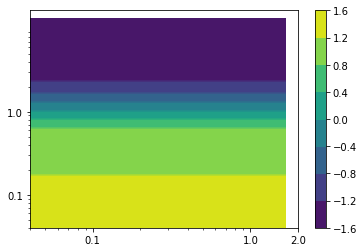

In [1921]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
# Step 2: Create 2D array
#data =np.log10(np.median(structure3d,axis=0).T)  # Example 10x10 random array
data = np.log10(log_structure)
# Step 3: Define logarithmically spaced x and y values


# Step 4: Plot the image
#plt.imshow(data, origin='lower',extent=[0.04, 2,0.04,5],cmap=cmap,vmin=-2,vmax=1)
plt.contour(bin_edges, ylog, np.log10(log_structure).T)
plt.contourf(bin_edges,ylog, np.log10(log_structure).T)

#plt.contour(ylog,bin_edges, np.log10(log_structure),cmap=cmap,vmin=-2,vmax=1)
#plt.contourf(ylog,bin_edges ,np.log10(log_structure) ,cmap=cmap,vmin=-2,vmax=1)


# Step 5: Set logarithmic scale for x and y axes
plt.xscale('log')
plt.yscale('log')
plt.xticks([0.1, 0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1, ])
plt.yticks([0.1, 0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xticks([0.1, 1,2])

plt.yticks([0.1, 16])

plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
#plt.grid(which="both", linewidth=0.72,color="k")
plt.colorbar()

# Display the plot
plt.show()


/cosma/home/dp004/dc-aram1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


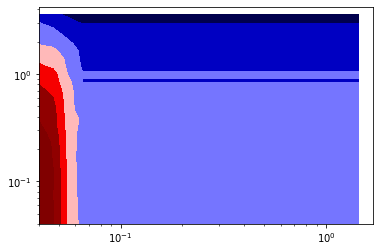

In [1407]:
fig,ax=plt.subplots(1,1)

cp = ax.contourf(10**xlog,10**ylog, np.log10(log_structure.T) ,cmap=cmap,vmin=-2,vmax=1)
ax.set_xscale('log')
ax.set_yscale('log')


/cosma/home/dp004/dc-aram1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


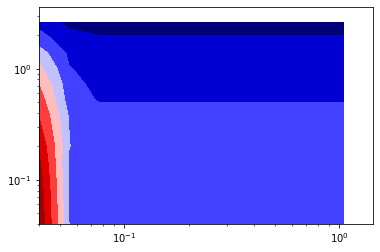

In [1402]:
fig,ax=plt.subplots(1,1)

cp = ax.contourf(10**xlog,10**ylog, np.log10(log_structure.T) ,cmap=cmap)
ax.set_xscale('log')
ax.set_yscale('log')

#ax.set_xlim(np.log10(0.08),2)
#ax.set_ylim(np.log10(0.08),2)

In [1387]:
np.shape(np.median(structure3d,axis=0).T)

(817, 200)

In [1038]:
xlist = np.linspace(0, 2, 100)
ylist = np.linspace(0, 16, 817)


In [1298]:
np.argmax(np.median(structure3d,axis=0))

0

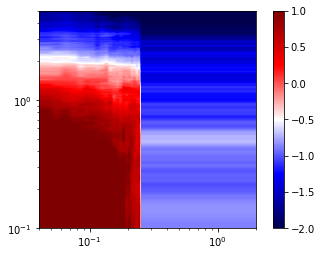

In [1309]:
plt.imshow(np.log10(np.median(structure3d,axis=0).T), origin='lower',extent=[0.04, 2,0.1,5],vmin=-2,vmax=1,cmap='seismic')
plt.xscale('log')
plt.colorbar()
plt.yscale('log')

/cosma/home/dp004/dc-aram1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


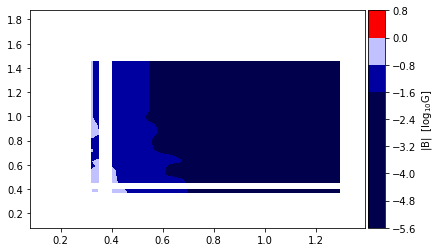

In [706]:
fig,ax=plt.subplots(1,1)

cp = ax.contourf(10**xlog, 10**ylog, np.log10(log_structure.T) ,cmap=cmap,vmin=-1.5,vmax=1)
#ax.set_xlim(-0.5,0)
#ax.set_ylim(-0.4,0.2)
cax = inset_axes(ax,
                     width="5%",  # width = 50% of parent_bbox width
                     height="100%",  # height : 5%
                     borderpad = -2,
                     loc='right')
#                    bbox_to_anchor=(1.05, 0., 1, 1)
cbar =plt.colorbar(cp,cax=cax,orientation="vertical",label = "$\mathrm{|B|}$  [$\mathrm{log}_{10} \mathrm{G}$]")
#ax.set_xlim(np.log10(1),0)
#ax.set_ylim(np.log10(1),0)

/cosma/home/dp004/dc-aram1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


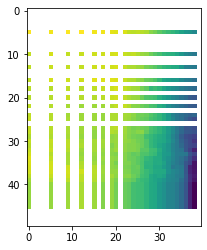

In [679]:
plt.imshow(np.log10(log_structure).T)

In [590]:
structure = []
for j in range(40):
    los_append = []
    center_pixel = []
    for i in range(50):
        actual_los = gals12p5['gal_'+str(i)]['LOS_'+str(j)]['Hydrogen']['H I']['optical depth-weighted']['Optical depths'][los_start_indx:los_end_indx]
        los_append.append(actual_los[:center_indx+2])

        
    median_los = np.median(los_append,axis=0)
#    median_centr = np.median(center_pixel)
    averged = []
    for left,right in zip(indx_edges_left,indx_edges_right):
        averged.append(np.average(median_los[left:right]))
        
 #   averged.append(median_centr)
    
    structure.append(np.flip(averged))
    
    



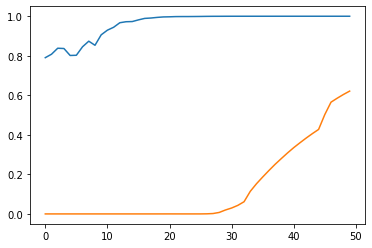

In [597]:
plt.plot(np.exp(-structure[-1]))
plt.plot(np.exp(-structure[0]))

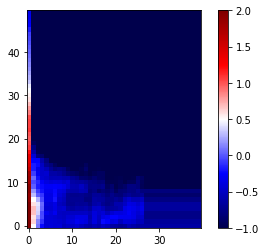

In [600]:
from matplotlib.colors import LogNorm
plt.imshow(np.log10(np.array(structure).T),origin='lower',cmap='seismic')
plt.clim(-1,2)
plt.colorbar()


In [581]:
Z= np.array(structure)


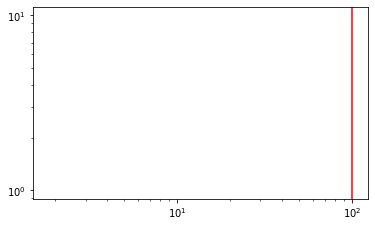

In [609]:
import matplotlib.pyplot as plt
import numpy as np

#x = np.logspace(1, 3, 5)
#y = np.logspace(0, 2, 3)
z = np.linspace(0, 1, 40)
Z = np.vstack((z, z))

plt.imshow(Z, extent=[0, 1.5, 0, 2], cmap='gray')
plt.xscale('log')
plt.yscale('log')

plt.axvline(100, color='red')

plt.show()

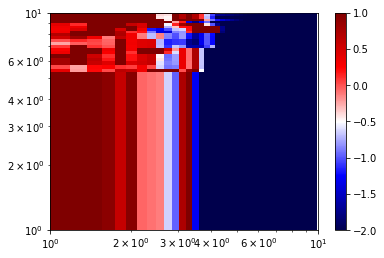

In [575]:
x = np.logspace(0, 1, 40)  # Example logarithmic x values
y = np.logspace(0, 1, 50)  # Example logarithmic y values
data=np.log10(Z).T
# Step 4: Plot the image
plt.imshow(np.log10(Z).T, extent=[x.min(), x.max(), y.min(), y.max()],vmin=-2,vmax=1,aspect='auto',cmap='seismic')
#cbar.set_ticks([0, 0.5, 1])  # Set custom ticks on the colorbar
cbar.set_label('Colorbar Label')  # Set label for the colorbar
# Adjust the colorbar limits
#cbar.set_clim(0, 1)


plt.xscale('log')
plt.yscale('log')

# Step 6: Add colorbar
plt.colorbar()


AttributeError: 'Colorbar' object has no attribute 'set_clim'

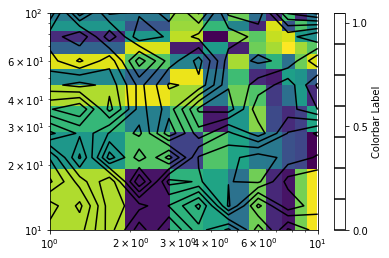

In [363]:
import numpy as np
import matplotlib.pyplot as plt

# Step 2: Create 2D array
data = np.random.rand(10, 10)  # Example 10x10 random array

# Step 3: Define logarithmically spaced x and y values
x = np.logspace(0, 1, 10)  # Example logarithmic x values
y = np.logspace(1, 2, 10)  # Example logarithmic y values

# Step 4: Plot the image
plt.imshow(data, extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto')

# Step 5: Set logarithmic scale for x and y axes
plt.xscale('log')
plt.yscale('log')

# Step 6: Add contours
contours = plt.contour(x, y, data, colors='black')  # Add contours to the plot

# Step 7: Add colorbar with adjusted limits
cbar = plt.colorbar()
cbar.set_ticks([0, 0.5, 1])  # Set custom ticks on the colorbar
cbar.set_label('Colorbar Label')  # Set label for the colorbar

# Adjust the colorbar limits
cbar.set_clim(0, 1)

# Display the plot
plt.show()

In [578]:
npix_x   = 50 
npix_y   = 40
xmin    = 0.08 
xmax    = 2
ymin    = 0.08 
ymax    = 1.5

dx_log = (np.log10(xmax)-np.log10(xmin))/npix_x
xlog   = np.log10(xmin) + np.arange(npix)*dx_log

dy_log = (np.log10(ymax)-np.log10(ymin))/npix_y
ylog   = np.log10(ymin) + np.arange(npix_y)*dy_log


print(xlog)

log_structure = np.zeros((npix_x,npix_y))

[-1.09691001 -1.06895121 -1.04099241 -1.01303361 -0.98507481 -0.95711601
 -0.92915721 -0.90119841 -0.87323961 -0.84528081 -0.81732201 -0.78936321
 -0.76140441 -0.73344561 -0.70548681 -0.67752801 -0.64956921 -0.62161041
 -0.59365161 -0.56569281 -0.53773401 -0.50977521 -0.48181641 -0.45385761
 -0.42589881 -0.39794001 -0.36998121 -0.34202241 -0.31406361 -0.28610481
 -0.25814601 -0.23018721 -0.20222841 -0.17426961 -0.14631081 -0.11835201
 -0.09039321 -0.06243441 -0.03447561 -0.00651681  0.02144199  0.04940079
  0.07735959  0.10531839  0.13327719  0.16123599  0.18919479  0.2171536
  0.2451124   0.2730712 ]


In [611]:
10**ylog

array([0.08      , 0.08608253, 0.09262752, 0.09967014, 0.10724823,
       0.11540248, 0.12417672, 0.13361807, 0.14377727, 0.15470889,
       0.16647166, 0.17912877, 0.19274822, 0.20740317, 0.22317237,
       0.24014053, 0.2583988 , 0.27804528, 0.29918551, 0.32193307,
       0.34641016, 0.37274829, 0.40108894, 0.43158438, 0.46439844,
       0.4997074 , 0.53770096, 0.57858324, 0.62257385, 0.66990915,
       0.72084342, 0.77565031, 0.83462426, 0.89808209, 0.96636472,
       1.039839  , 1.11889963, 1.20397138, 1.29551127, 1.39401109])

In [580]:
xlist = np.linspace(0, 2, 50)
ylist = np.linspace(0, 1.5, 40)
X, Y = np.meshgrid(xlist, ylist)

In [582]:
np.shape(Z)

(40, 49)

In [356]:
for i,(xa,xb) in enumerate(zip(xlog[0:-1],xlog[1:])):    
    xleft  = 10**xa 
    xright = 10**xb 
    for j,(ya,yb) in enumerate(zip(ylog[0:-1],ylog[1:])):
        yleft = 10**ya
        yright = 10**yb
        
        mask = (X>=xleft) & (X<=xright) & (Y>=yleft) & (Y<=yright) 
        if np.sum(mask)>0:
            log_structure[i,j] = Z.T[mask]
levels = np.linspace(-1.2,0.8,20)
levels = -1.2 + np.arange(19) * 0.1            
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import ticker, cm
fig,ax=plt.subplots(1,1)
cp = ax.contour(xlog, xlog, np.log10(log_structure),cmap=cmap)

cp = ax.contourf(xlog, xlog, np.log10(log_structure) ,cmap=cmap)

ax.set_ylabel('y (cm)')

cax = inset_axes(ax,
                     width="5%",  # width = 50% of parent_bbox width
                     height="100%",  # height : 5%
                     borderpad = -2,
                     loc='right')
#                    bbox_to_anchor=(1.05, 0., 1, 1)
cbar =plt.colorbar(cp,cax=cax,orientation="vertical",label = "$\mathrm{|B|}$  [$\mathrm{log}_{10} \mathrm{G}$]")
#cbar.mappable.set_clim(-1,0.8)
ax.set_aspect('equal')

ax.set_xlim(np.log10(0.08),0)
ax.set_ylim(np.log10(0.08),0)
#plt.clim(-2.8,-2)



ValueError: setting an array element with a sequence.

In [322]:
npix   = 40 
xmin    = 0.08 
xmax    = 2
dx_log = (np.log10(xmax)-np.log10(xmin))/npix 
xlog   = np.log10(xmin) + np.arange(npix)*dx_log
xlist = np.linspace(0, 2, 40)
ylist = np.linspace(0, 1, 50)
X, Y = np.meshgrid(xlist, ylist)


array([[0.        , 0.05128205, 0.1025641 , ..., 1.8974359 , 1.94871795,
        2.        ],
       [0.        , 0.05128205, 0.1025641 , ..., 1.8974359 , 1.94871795,
        2.        ],
       [0.        , 0.05128205, 0.1025641 , ..., 1.8974359 , 1.94871795,
        2.        ],
       ...,
       [0.        , 0.05128205, 0.1025641 , ..., 1.8974359 , 1.94871795,
        2.        ],
       [0.        , 0.05128205, 0.1025641 , ..., 1.8974359 , 1.94871795,
        2.        ],
       [0.        , 0.05128205, 0.1025641 , ..., 1.8974359 , 1.94871795,
        2.        ]])

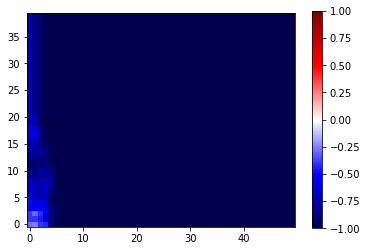

In [323]:
plt.imshow(np.log10(Z.T),origin='lower',cmap='seismic')
plt.clim(-1,1)
plt.colorbar()

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

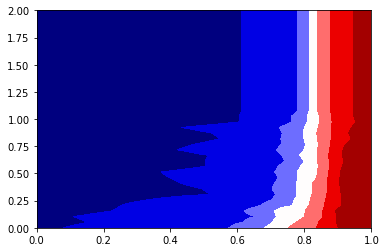

In [317]:

fig,ax=plt.subplots(1,1)
cp = ax.contourf(Y, X, Z,locator=ticker.LogLocator(),cmap='seismic')#,vmin=-1,vmax=1)
#plt.clim(-1,1)
plt.colorbar()

TypeError: Length of y (40) must match number of rows in z (50)

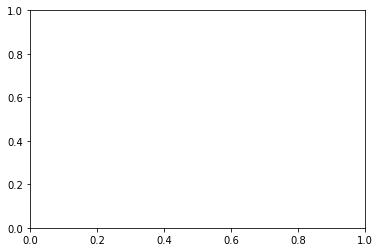

In [297]:
levels = np.linspace(-1.2,0.8,20)
levels = -1.2 + np.arange(19) * 0.1
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import ticker, cm
cmap='seismic'
fig,ax=plt.subplots(1,1)
cp = ax.contour(xlog, xlog, np.log10(log_structure),cmap=cmap)

cp = ax.contourf(xlog, xlog, np.log10(log_structure) ,cmap=cmap)

ax.set_ylabel('y (cm)')

cax = inset_axes(ax,
                     width="5%",  # width = 50% of parent_bbox width
                     height="100%",  # height : 5%
                     borderpad = -2,
                     loc='right')
#                    bbox_to_anchor=(1.05, 0., 1, 1)
cbar =plt.colorbar(cp,cax=cax,orientation="vertical",label = "$\mathrm{|B|}$  [$\mathrm{log}_{10} \mathrm{G}$]")
#cbar.mappable.set_clim(-1,0.8)
ax.set_aspect('equal')

ax.set_xlim(np.log10(0.08),0)
ax.set_ylim(np.log10(0.08),0)
#plt.clim(-2.8,-2)



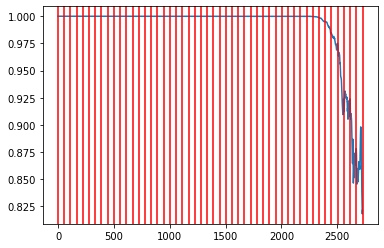

In [244]:
plt.plot(np.exp(-np.median(los_append,axis=0)))
for x in indx_edges:
    plt.axvline(x=x,c='r')

In [257]:
meangss = np.median(los_append,axis=0)

In [264]:
averged

[8.350577922669824e-07,
 8.732683498951224e-07,
 9.141637060970798e-07,
 9.580218575707528e-07,
 1.0055646489954565e-06,
 1.0562810348673463e-06,
 1.1109897903571697e-06,
 1.1706965849476085e-06,
 1.2349290153442053e-06,
 1.3050340969924607e-06,
 1.382191454631573e-06,
 1.4684763768203714e-06,
 1.568450154126202e-06,
 1.6865470879810824e-06,
 1.7974794503882369e-06,
 1.9042532217524373e-06,
 2.0197736293240804e-06,
 2.1462251609404807e-06,
 2.2862926069637893e-06,
 2.4391452507629595e-06,
 2.608007416901864e-06,
 2.7950933859375454e-06,
 3.003278694527201e-06,
 3.2379870281517486e-06,
 3.4990295428296244e-06,
 3.846922682786256e-06,
 4.317530554124531e-06,
 6.114761303035511e-06,
 9.154296766818982e-06,
 1.6321421696195482e-05,
 2.45952583636082e-05,
 3.166447040248726e-05,
 4.3026818093428705e-05,
 7.178844350972304e-05,
 0.00014327432420575007,
 0.00031101029235734034,
 0.0005225522765118513,
 0.0010828085092445894,
 0.0018675315649554023,
 0.004293998578777541,
 0.006223453589418462

In [258]:
meangss = np.median(los_append,axis=0)
averged = []
for left,right in zip(indx_edges_left,indx_edges_right):
    averged.append(np.average(meangss[left:right]))

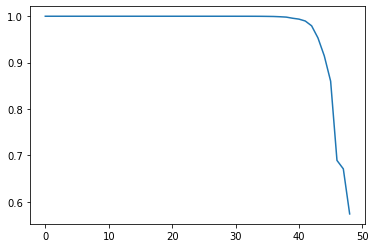

In [259]:
plt.plot(np.exp(-np.array(averged)))

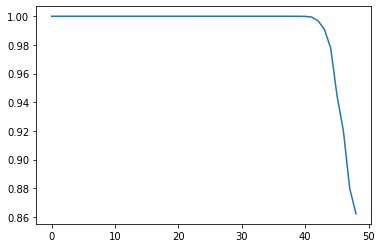

In [254]:
plt.plot(np.exp(-np.array(averged)))

In [238]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

2677

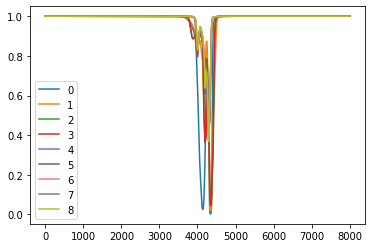

In [95]:
for i in range(10)[:9]:
    plt.plot(np.exp(-projections_extended[i]['OpticaldepthWeighted'][('Hydrogen',
  'H I')]['Optical depths']['Value'][4000:12000]),label=str(i))
plt.legend()

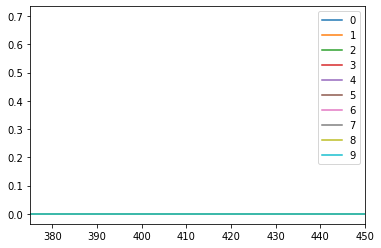

In [79]:

for i in range(10):
    plt.plot(np.exp(projections_extended[i]['Projected']['Mass-weighted']['Densities']['Value']),label=str(i))
    plt.xlim(375,450)
plt.legend()

In [104]:
projections_extended[0].keys()

dict_keys(['nsight', 'OpticaldepthWeighted', 'Projected'])

In [99]:
galh5 = h5py.File("galaxy_metals.h5py",'a')

In [126]:
projections_extended[0]['Projection'].keys()

dict_keys(['pixel', 'pixel_kms', 'npix', 'Header', 'Element-weighted', 'Ion-weighted', 'Mass-weighted'])